# `やまびこ`シミュレーション


In [66]:
# -*- coding: utf-8 -*-
# basic libraries
import os
import json
from pathlib import Path

# third party
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

# GIS
import tifffile
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.transform import rowcol
from rasterio.warp import transform as reproject_pts

PATH_OUTPUT = 'output/006/'
if not os.path.exists(PATH_OUTPUT):
    os.makedirs(PATH_OUTPUT, exist_ok=True)

## 音速解析

**断熱**な圧力変化に対する状態方程式の勾配から定義は以下。

$$
c^2 = \left( \frac{\partial p}{\partial \rho} \right)_s
$$

ここで

* $c$：音速 \[m/s]
* $p$：圧力 \[Pa]
* $\rho$：密度 \[kg/m^3]
* 添字 $s$：等エントロピー（断熱）

理想気体の状態方程式 $p = \rho R T$ と、定圧比熱 $c_p$・定積比熱 $c_v$ から定まる比熱比 $\gamma = c_p/c_v$ を用います。

上式を代入すると：

$$
c^2 = \gamma \frac{p}{\rho}
$$

理想気体：$\rho = \frac{p}{R T}$ より、

$$
c^2 = \gamma R T
\quad\Rightarrow\quad
c = \sqrt{\gamma R T}.
$$

乾燥空気に対して代表値を入れると（$\gamma \approx 1.4$, $R_d = 287.05$ J/(kg·K)):

$$
c = \sqrt{1.4 \times 287.05 \times T} \approx 20.05\sqrt{T} \quad [\mathrm{m/s}], \; T[\mathrm{K}].
$$

温度を摂氏 $T_{°C}$ で与えた場合、$T = T_{°C} + 273.15$.

**注意:** 上記の式では $p$ が消えてしまうため、乾燥理想空気では音速は温度のみで決まります。観測した気圧から音速を推定したい場合は、(1) 非理想効果、(2) 湿度による混合気体効果、(3) 組成変化（CO₂ 等）を考慮する必要があります。


気圧と温度が与えられ、相対湿度 RH（0〜1）が別途得られる場合、以下の手順で混合気体定数と有効温度（仮温度・仮想温度）を計算し、音速を推定できます。

$$
e_s(T_{°C}) = 6.112 \exp\left(\frac{17.67 T_{°C}}{T_{°C} + 243.5}\right) \quad [\mathrm{hPa}]
$$

### 実際の水蒸気圧

$$
e = \mathrm{RH} \cdot e_s.
$$

### 混合比 $w$（乾燥空気質量に対する水蒸気質量）

$$
w = \epsilon \frac{e}{p - e}, \qquad \epsilon = \frac{R_d}{R_v} \approx 0.622.
$$

### 比湿（specific humidity）$q$

$$
q = \frac{w}{1 + w}.
$$

### 仮想温度 $T_v$（簡易近似）

$$
T_v \approx T_K (1 + 0.61 q).
$$

（より厳密には $T_v = T_K \left(1 + \frac{R_v}{R_d}q\right) / (1+q)$ などの式がありますが、0.61q 近似は実用的です。）

### 混合気体のガス定数と比熱

質量加重で混合します（簡易）:

$$
R_{mix} = R_d (1-q) + R_v q.
$$

$$
c_{p,mix} = c_{p,d}(1-q) + c_{p,v}q.
$$

$$
c_{v,mix} = c_{p,mix} - R_{mix}.
$$

$$
\gamma_{mix} = \frac{c_{p,mix}}{c_{v,mix}}.
$$

### 湿り空気での音速

$$
c = \sqrt{\gamma_{mix} \, R_{mix} \, T_v }.
$$

このモデルでは $p$ が式に残り、RH とともに音速がわずかに変化します（特に高温・高湿条件で顕著）。

Example dry  : P=1013.25 hPa, T=15.0 °C -> c=340.29 m/s
Example moist : P=1013.25 hPa, T=15.0 °C, RH=0.20 -> c=340.67 m/s


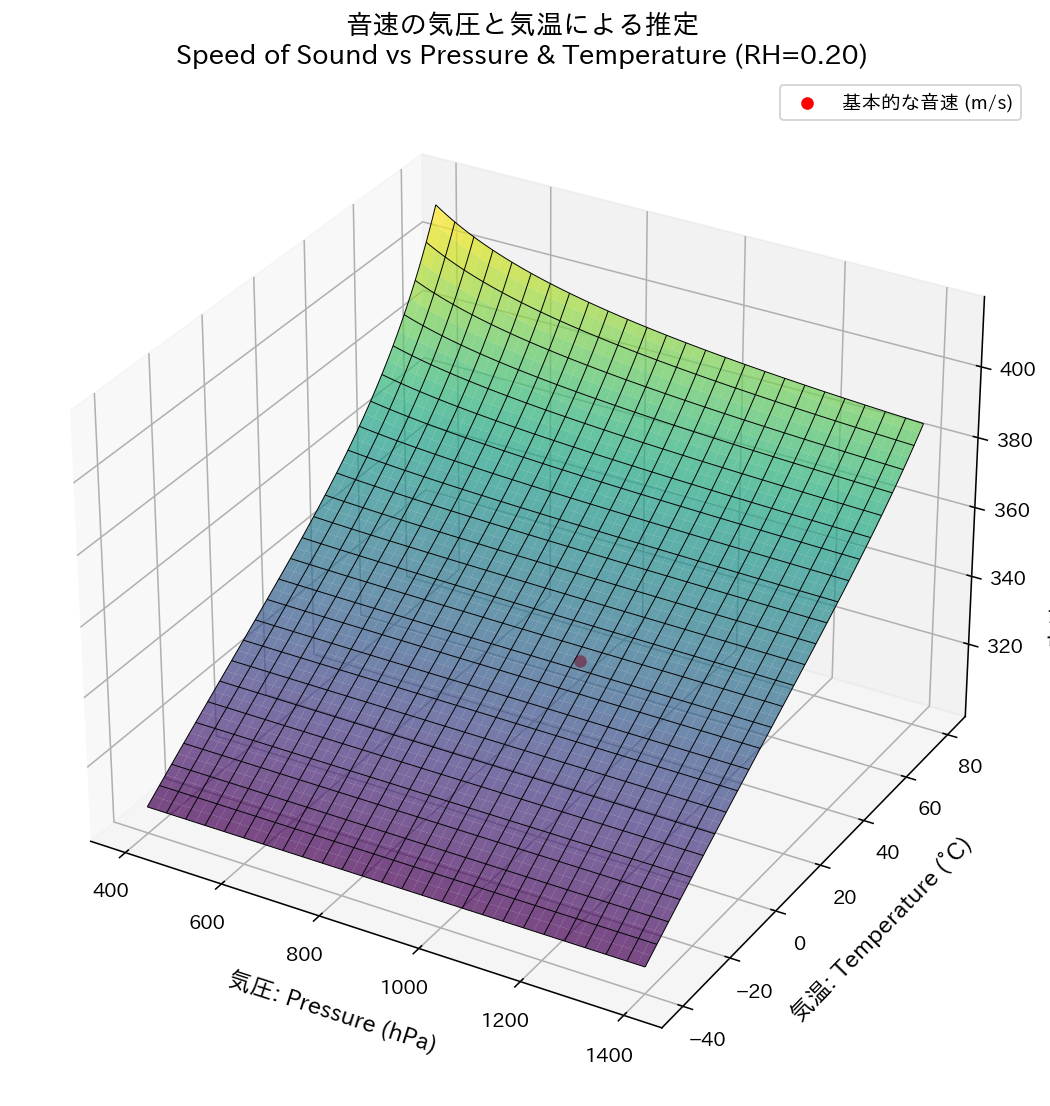

,pressure_hPa,temperature_C,c_dry_mps,c_moist_mps_RH20
0,1200.00,-30,312.593491,312.582574
1,1200.00,0,331.316753,331.413401
2,1200.00,15,340.292287,340.608637
3,1200.00,30,349.037090,349.880632
4,1200.00,70,371.351169,378.311055
5,1013.25,-30,312.593491,312.584288
6,1013.25,0,331.316753,331.435173
7,1013.25,15,340.292287,340.671082
8,1013.25,30,349.037090,350.040791
9,1013.25,70,371.351169,379.630550


In [67]:
# --- 定数 ---
R_d = 287.05   # J/(kg*K) 乾燥空気
R_v = 461.5    # J/(kg*K) 水蒸気
cp_d = 1005.0  # J/(kg*K)
cp_v = 1850.0  # J/(kg*K) 近似

def speed_of_sound_dry_air(T_K, gamma=1.4):
    """乾燥空気（理想気体）音速 [m/s]。T_K: Kelvin。"""
    return np.sqrt(gamma * R_d * T_K)

def saturation_vapor_pressure_hPa(T_C):
    """Tetens式による飽和水蒸気圧 [hPa]; -40～+50℃程度で有効な近似。"""
    return 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))

def specific_humidity(P_hPa, T_C, RH=0.5):
    """比湿 q [kg/kg] を気圧[hPa], 気温[°C], 相対湿度RH[0-1]から推定。"""
    e_s = saturation_vapor_pressure_hPa(T_C)  # hPa
    e = RH * e_s
    eps = R_d / R_v  # ~0.622
    w = eps * e / (P_hPa - e)  # mixing ratio
    q = w / (1 + w)
    return q

def speed_of_sound_moist_air(P_hPa, T_C, RH=0.5):
    """湿り空気音速 [m/s]（仮想温度 & 混合気体比熱近似）。"""
    q = specific_humidity(P_hPa, T_C, RH=RH)
    T_K = T_C + 273.15
    # 仮想温度 (簡易)
    T_v = T_K * (1.0 + 0.61 * q)
    # 混合気体の cp, R, gamma
    cp_mix = cp_d * (1 - q) + cp_v * q
    R_mix  = R_d  * (1 - q) + R_v  * q
    cv_mix = cp_mix - R_mix
    gamma_mix = cp_mix / cv_mix
    return np.sqrt(gamma_mix * R_mix * T_v)

# ---- 計算グリッド ----
pressure_range_hPa = np.linspace(400, 1400, 200)  # 地表付近の気圧範囲に変更（必要なら調整）
temperature_range_C = np.linspace(-40, 80, 200)

P_grid, T_grid = np.meshgrid(pressure_range_hPa, temperature_range_C)

# RH 設定（0=乾燥, 1=飽和）
RH_demo = 0.2
c_grid = speed_of_sound_moist_air(P_grid, T_grid, RH=RH_demo)

# 乾燥モデル（気圧非依存）も計算（比較用）
c_grid_dry = speed_of_sound_dry_air(T_grid + 273.15)

# 代表条件
P0_hPa = 1013.25
T0_C = 15.0
c0_dry = speed_of_sound_dry_air(T0_C + 273.15)
c0_moist = speed_of_sound_moist_air(P0_hPa, T0_C, RH=RH_demo)
print(f"Example dry  : P={P0_hPa:.2f} hPa, T={T0_C:.1f} °C -> c={c0_dry:.2f} m/s")
print(f"Example moist : P={P0_hPa:.2f} hPa, T={T0_C:.1f} °C, RH={RH_demo:.2f} -> c={c0_moist:.2f} m/s")

# ---- 3D プロット ----
fig = plt.figure(figsize=(14, 8), dpi=140, facecolor="w", edgecolor="k")
ax = fig.add_subplot(111, projection='3d')
# Note: カラー指定しない（指示に従う）
ax.plot_surface(P_grid, T_grid, c_grid, linewidth=0, antialiased=True, alpha=0.7,
                cmap='viridis', 
                # label="Sound Speed (m/s)",
                label='_nolegend_'
                )
ax.plot_wireframe(P_grid, T_grid, c_grid, rstride=8, cstride=8, linewidth=0.5,
                  color='k', )  # ワイヤーフレーム
ax.scatter(P0_hPa, T0_C, c0_moist, s=30, c='r',
           label="基本的な音速 (m/s)")  # 代表点
ax.set_xlabel('気圧: Pressure (hPa)', fontsize=12, labelpad=8)
ax.set_ylabel('気温: Temperature (°C)', fontsize=12, labelpad=8)
ax.set_zlabel('音速: Speed of Sound (m/s)', fontsize=12, labelpad=8)
ax.set_title(f'音速の気圧と気温による推定\nSpeed of Sound vs Pressure & Temperature (RH={RH_demo:.2f})', fontsize=14)
ax.legend()
ax.view_init(elev=30, azim=-60)  # 視点調
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'speed_of_sound_3d.png'),)
plt.show()

# ---- サンプル値テーブル ----
example_pressures = [1200, 1013.25, 900, 800, 100]  # hPa
example_temps = [-30, 0, 15, 30, 70]              # °C
rows = []
for p in example_pressures:
    for t in example_temps:
        rows.append({
            'pressure_hPa': p,
            'temperature_C': t,
            'c_dry_mps': speed_of_sound_dry_air(t + 273.15),
            f'c_moist_mps_RH{int(RH_demo*100)}': speed_of_sound_moist_air(p, t, RH=RH_demo),
        })
df = pd.DataFrame(rows)
df

## 空気吸収量解析

ISO 9613-1（1993）では、純音（50 Hz–10 kHz）の**大気吸収減衰係数 α \[dB m–1]** が

$$
\alpha(f,T,{\rm RH},p)=8.686\,f^{2}\Bigl[
1.84{\times}10^{-11}\,\frac{p_{\mathrm r}}{p}\sqrt{\frac{T}{T_{0}}}
+\Bigl(\frac{T}{T_{0}}\Bigr)^{-\!5/2}
\Bigl(
\frac{0.01275\,e^{-2239.1/T}}{f_{r{\rm O}}+\dfrac{f^{2}}{f_{r{\rm O}}}}
+\frac{0.1068\,e^{-3352/T}}{f_{r{\rm N}}+\dfrac{f^{2}}{f_{r{\rm N}}}}
\Bigr)
\Bigr]

$$

で与えられます（T: K, f: Hz, p: Pa）。酸素・窒素の**緩和周波数**は

$$
\begin{aligned}
f_{r\mathrm O}&=\frac{p}{p_{\mathrm r}}\left[24+4.04{\times}10^{4}\,h\frac{0.02+h}{0.391+h}\right],\\
f_{r\mathrm N}&=\frac{p}{p_{\mathrm r}}\Bigl(\tfrac{T}{T_{0}}\Bigr)^{-1/2}
\left[9+280h\,e^{-4.17\bigl( (T/ T_{0})^{-1/3}-1\bigr)}\right],
\end{aligned}
$$

ここで $h$ は水蒸気の**モル分率**（相対湿度と温度から決定）です。詳しい導出は ISO 9613-1 本文を参照してください。(以下)

> Calculation of the Absorption of Sound by the Atmosphere
(ISO 9613-1)


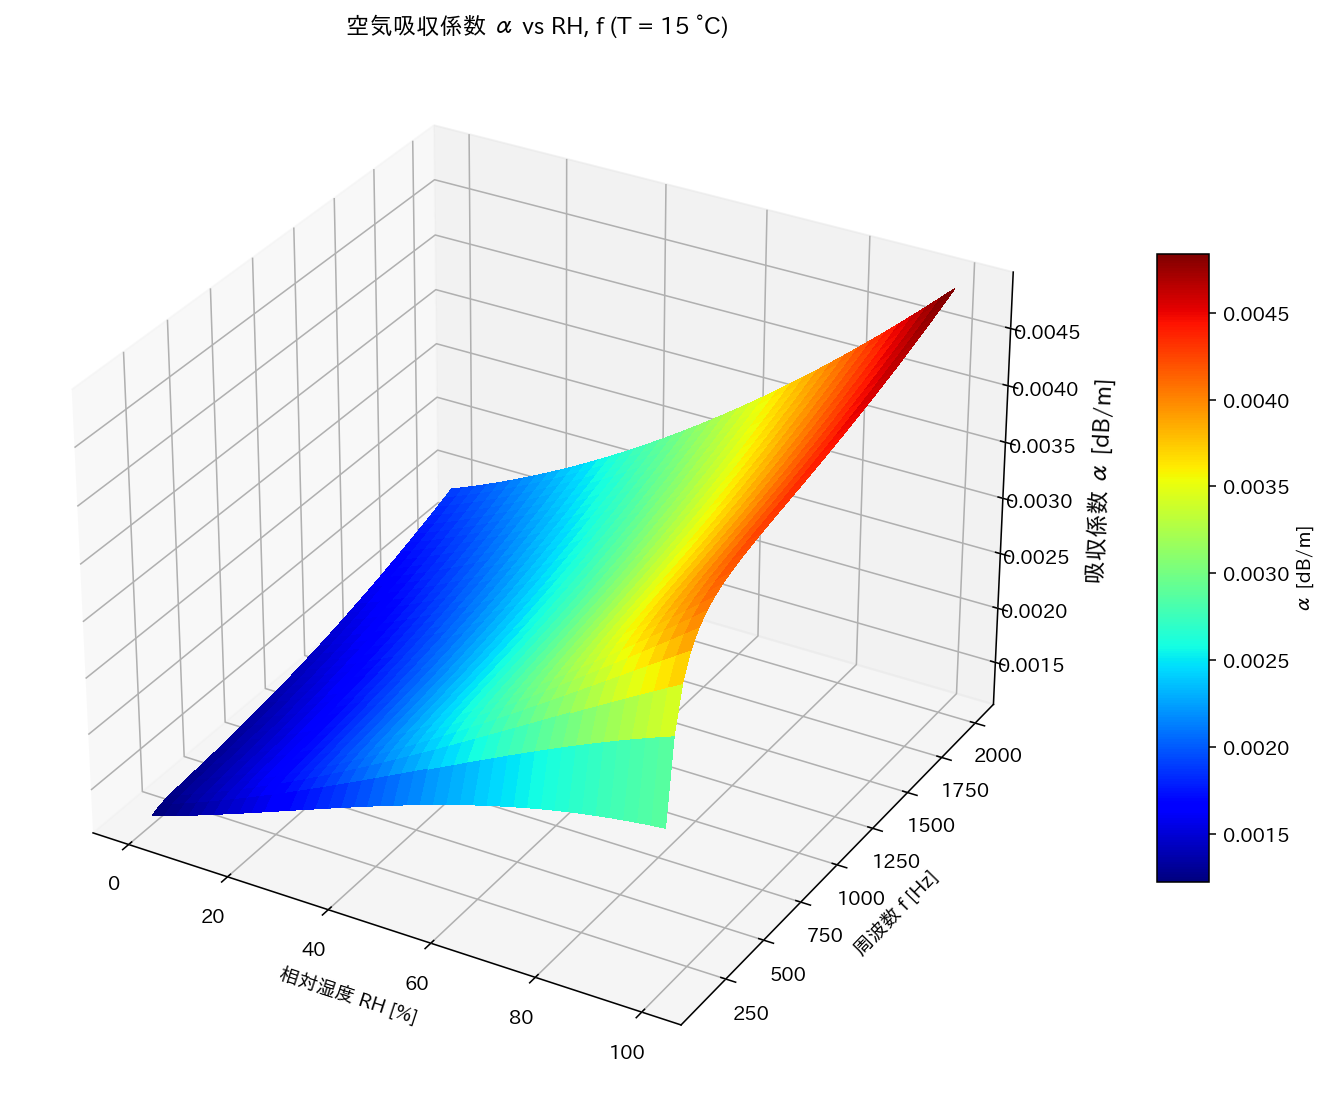

In [68]:
# --- alpha_iso9613 関数を再掲 ---
def saturation_pressure_pa(T_c):
    return 610.78 * 10 ** (7.5 * T_c / (T_c + 237.3))

def alpha_iso9613(f_hz, T_c, RH, p_pa=101325):
    T0 = 293.15
    pr = 101325.0

    T = T_c + 273.15
    f = f_hz

    Psat = 610.78 * 10 ** (7.5 * T_c / (T_c + 237.3))
    h = RH / 100 * Psat / p_pa

    FrO = (p_pa / pr) * (24 + 4.04e4 * h * (0.02 + h) / (0.391 + h))
    FrN = (p_pa / pr) * (T / T0) ** (-0.5) * (9 + 280 * h * np.exp(-4.17 * ((T / T0) ** (-1/3) - 1)))

    term1 = 1.84e-11 * (pr / p_pa) * np.sqrt(T / T0)
    term2 = (T / T0) ** (-2.5) * (
        0.01275 * np.exp(-2239.1 / T) / (FrO + (f ** 2) / FrO)
        + 0.1068 * np.exp(-3352.0 / T) / (FrN + (f ** 2) / FrN)
    )
    alpha = 8.686 * f ** 2 * (term1 + term2)
    return alpha

T_c_fixed = 15.0  # 15 ℃ の断面で可視化
RH_range = np.linspace(0, 100, 40)       # 湿度 [%]
f_range  = np.linspace(100, 2000, 40)    # 周波数 [Hz]

RH_mesh, f_mesh = np.meshgrid(RH_range, f_range)
alpha_mesh = alpha_iso9613(f_mesh, T_c_fixed, RH_mesh)

# 3D surface plot
fig = plt.figure(figsize=(14, 8), dpi=140, facecolor="w", edgecolor="k")
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(RH_mesh, f_mesh, alpha_mesh,
                       cmap=cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('相対湿度 RH [%]')
ax.set_ylabel('周波数 f [Hz]')
ax.set_zlabel('吸収係数 α [dB/m]', fontsize=12, labelpad=10)
ax.set_title(f'空気吸収係数 α vs RH, f (T = {T_c_fixed:.0f} °C)')
fig.colorbar(surf, shrink=0.6, aspect=12, label='α [dB/m]')

plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'air_absorption_3d_fixed.png'))   
plt.show()

In [69]:
# 例: 15 ℃, RH 20 %, 400 Hz
T_c = 15.0
RH = 20.0
f = 400.0  # Hz 理由は、男性で約100～500Hz、女性で約200～1000Hz程度

alpha_db_per_m = alpha_iso9613(f, T_c, RH)
alpha_db_per_km = alpha_db_per_m * 1000

print(f"気温 {T_c:.0f} ℃, RH {RH:.0f} %, 周波数 {f/1000:.1f} kHz")
print(f"空気吸収係数 α ≈ {alpha_db_per_m:.4f} dB/m")
print(f"             ≈ {alpha_db_per_km:.2f} dB/km")

気温 15 ℃, RH 20 %, 周波数 0.4 kHz
空気吸収係数 α ≈ 0.0017 dB/m
             ≈ 1.67 dB/km


## やまびこの到達距離シミュレーション

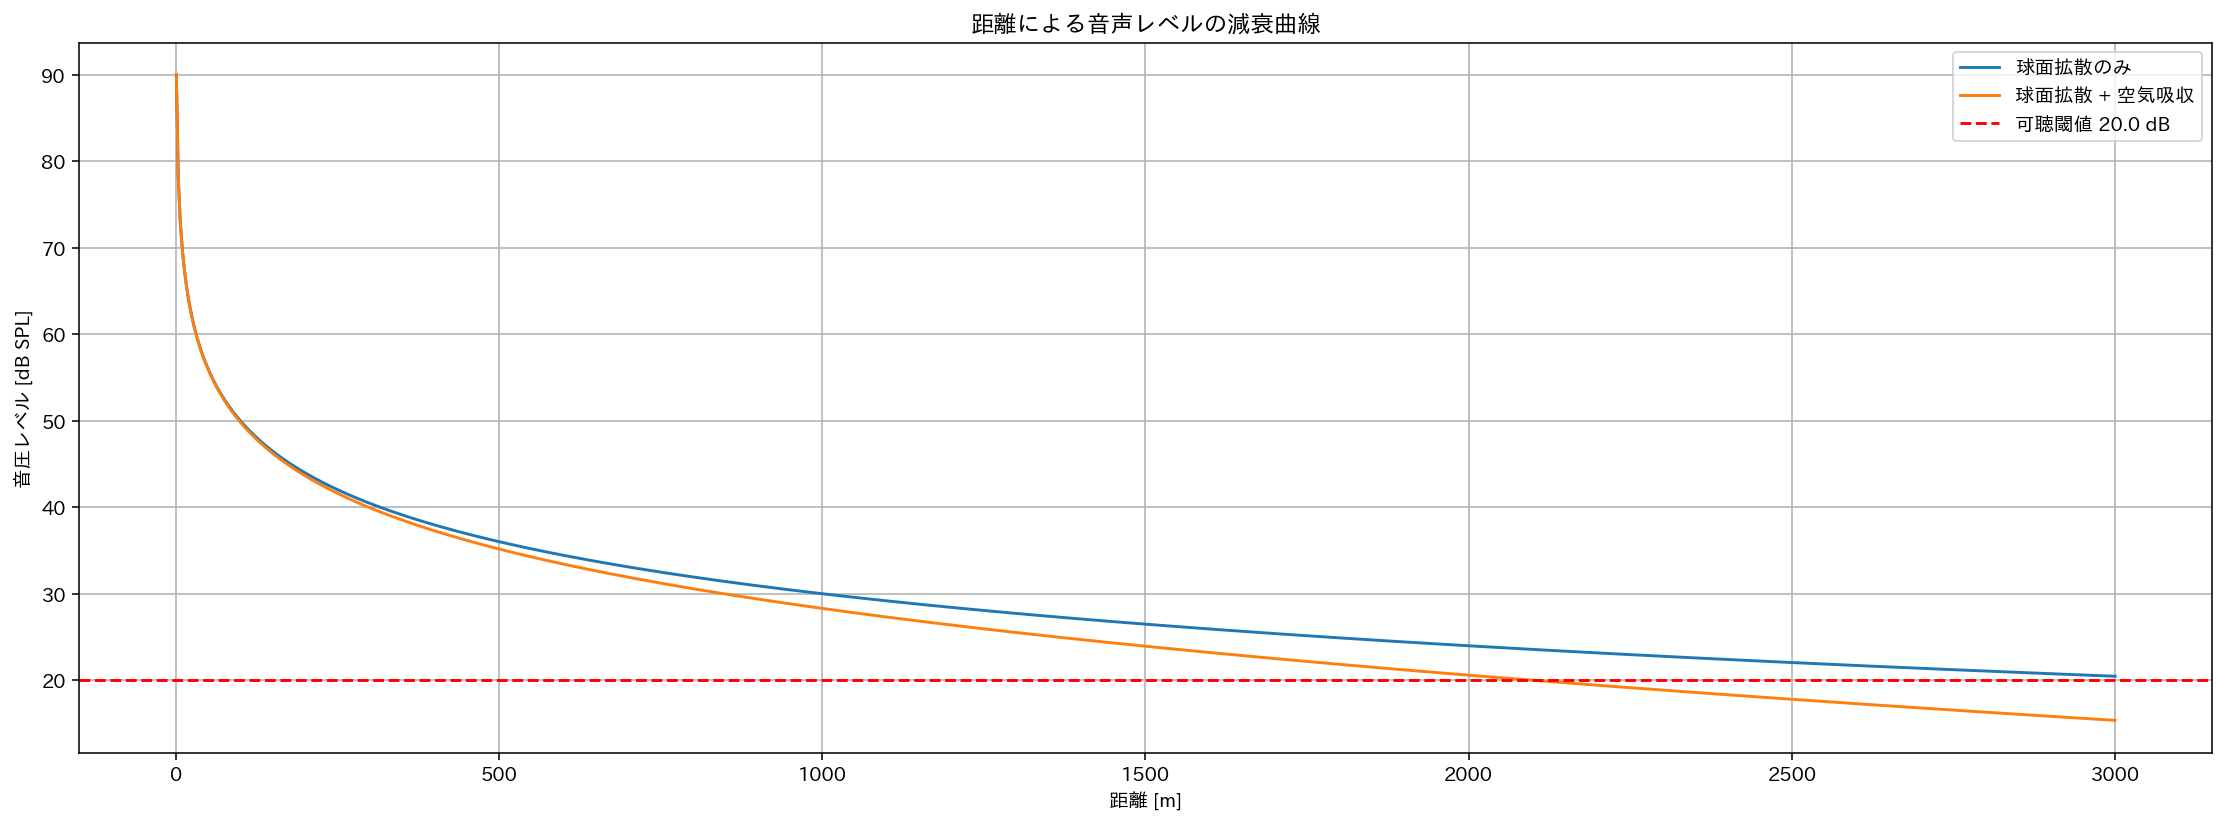

In [70]:
def geometric_level_db(L0_db, r_m, r0_m=1.0):
    """音源から r_m [m] 離れた地点での球面拡散のみのレベル[dB]"""
    return L0_db - 20.0 * np.log10(r_m / r0_m)

def total_level_db(L0_db, r_m, alpha_db_per_m, r0_m=1.0):
    """球面拡散 + 空気吸収（一次）の総合レベル[dB]"""
    geom = geometric_level_db(L0_db, r_m, r0_m)
    air  = alpha_db_per_m * (r_m - r0_m)
    return geom - air

# パラメータ
L0 = 90.0          # 1 m での音圧レベル [dB] 大声 -> 90くらい
alpha = 0.0017      # 吸収係数 [dB/m] (≈5 dB/km @1 kHz, 15 ℃)
distances = np.linspace(1, 3000, 1000)  # 1 m 〜 3 km
thresh_dB = 20.0  # 可聴閾値 [dB SPL]

# 計算
level_geom   = geometric_level_db(L0, distances)
level_total  = total_level_db(L0, distances, alpha)

# プロット
plt.figure(figsize=(16, 6), dpi=140, facecolor="w", edgecolor="k")
plt.plot(distances, level_geom, label="球面拡散のみ")
plt.plot(distances, level_total, label="球面拡散 + 空気吸収")
plt.axhline(thresh_dB, linestyle="--", label=f"可聴閾値 {thresh_dB} dB", color="r")
plt.xlabel("距離 [m]")
plt.ylabel("音圧レベル [dB SPL]")
plt.title("距離による音声レベルの減衰曲線")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'sound_level_attenuation.png'))
plt.show()


## リモートセンシングデータ

### AW3D

データ取得リンク: https://www.eorc.jaxa.jp/ALOS/en/aw3d30/data/html_v2404/dl/download_v2404.htm?N035E135_N036E137

In [71]:
ECHO_POINT_LATLON = (36.318,137.578)


# GeoDataFrame の作成
gdf = gpd.GeoDataFrame(
    {'name': ['Echo Point']},
    geometry=[Point(ECHO_POINT_LATLON[1], ECHO_POINT_LATLON[0])],
    crs='EPSG:4326'  # WGS84
)
gdf.to_file(
    os.path.join(PATH_OUTPUT, 'echo_point.geojson'), 
    driver='GeoJSON')

gdf

,name,geometry
0,Echo Point,POINT (137.57800 36.31800)


In [72]:
PATH_DEM = os.path.join("..", 'data/aw3d_kasagatake.tif')

with rasterio.open(PATH_DEM) as ds:
    raster_crs = ds.crs
    nodata = ds.nodata
    transform = ds.transform
    dem = ds.read(1)

    records = []
    # Reproject to raster CRS
    if gdf.crs is not None and raster_crs is not None and gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)

    # 座標配列
    xs = gdf.geometry.x.to_numpy()
    ys = gdf.geometry.y.to_numpy()

    # 行・列 (row, col)
    rows, cols = rowcol(transform, xs, ys)
    print(rows, cols)

    for (i, (r, c)) in enumerate(zip(rows, cols)):
        # 範囲チェック
        in_bounds = (
            (r >= 0) & (r < ds.height) &
            (c >= 0) & (c < ds.width)
        )
        print(f"有効なピクセル数: {in_bounds}")

        if in_bounds:
            try:
                # DEM 値取得
                vals = dem[r, c]
            except IndexError:
                vals = -1

        # レコード化
        rec = {
            "source_file": "dem",
            "feature_id": i,
            "x": xs[i] if in_bounds else None,
            "y": ys[i] if in_bounds else None,
            "pixel_x": int(c) if in_bounds else None,
            "pixel_y": int(r) if in_bounds else None,
            "dem": vals if in_bounds else np.nan,
        }
        records.append(rec)

# DataFrame
df = pd.DataFrame.from_records(records)
df.head()

[61] [90]
有効なピクセル数: True


,source_file,feature_id,x,y,pixel_x,pixel_y,dem
0,dem,0,137.578,36.318,90,61,2452


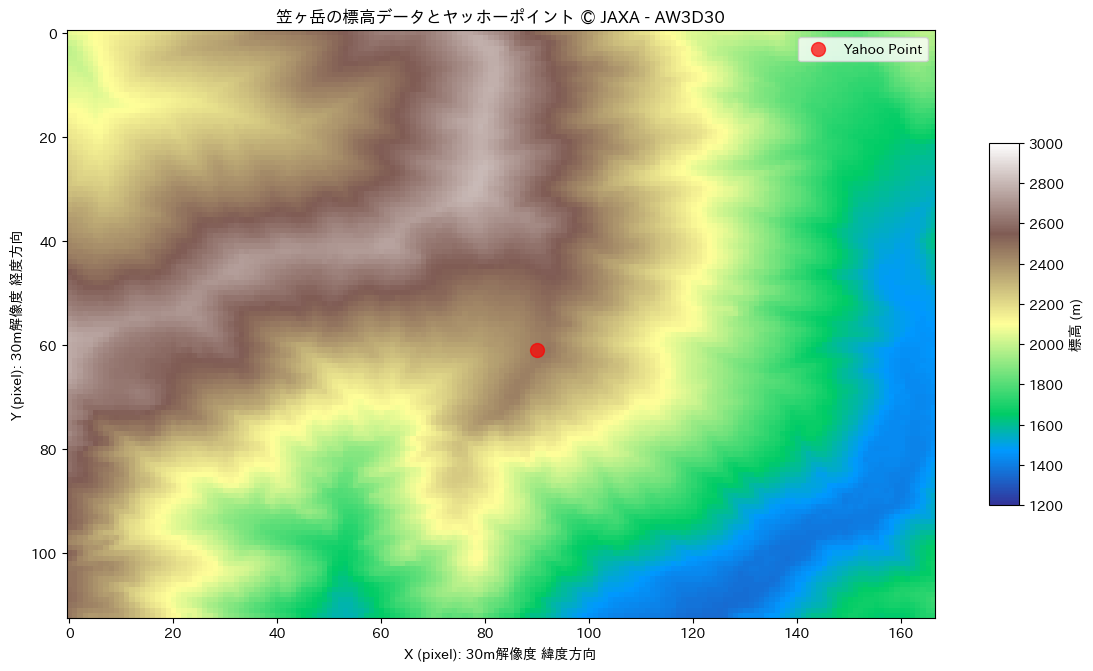

In [73]:
target_point = df.iloc[0]
dem = tifffile.imread(PATH_DEM)

# 点も同時に可視化
plt.figure(figsize=(14, 8), dpi=100, facecolor='white', edgecolor='black')
plt.imshow(dem, cmap='terrain', vmin=1200, vmax=3000)
plt.colorbar(label='標高 (m)', shrink=0.6, aspect=12)
plt.title('笠ヶ岳の標高データとヤッホーポイント © JAXA - AW3D30')
plt.xlabel('X (pixel): 30m解像度 緯度方向')
plt.ylabel('Y (pixel): 30m解像度 経度方向')
plt.scatter(target_point.pixel_x, target_point.pixel_y, color='red', 
    s=100, label='Yahoo Point', alpha=0.7)
plt.legend()
plt.grid(False)
plt.savefig(os.path.join(PATH_OUTPUT, 'kasagadake_yahoo.png'), bbox_inches='tight')
plt.show()

## 地形シミュレーション

In [74]:
def calculate_slope_aspect(dem, cell_size):
    """
    DEMデータから各地点の傾斜（度）と傾斜方位（度）を計算します。
    """
    # NumPyのgradient関数を用いて、Y方向とX方向の標高変化を計算
    # gradientは(dy, dx)の順で返すので注意
    dz_dy, dz_dx = np.gradient(dem, cell_size)
    
    # 傾斜を計算（ラジアンから度に変換）
    slope = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)) * 180 / np.pi
    
    # 傾斜方位を計算（北を0度とする地理的角度に変換）
    # arctan2の引数は(y, x)の順
    aspect = np.arctan2(-dz_dx, dz_dy) * 180 / np.pi
    aspect = (aspect + 360) % 360
    
    return slope, aspect

def has_line_of_sight(dem, source_pos, target_pos, source_height=1.5):
    """
    DEM上の2点間に見通しがあるかを確認します。
    音源の高さ（地上1.5m）を考慮します。
    """
    source_elev = dem[source_pos] + source_height
    target_elev = dem[target_pos]

    dx = target_pos[1] - source_pos[1]
    dy = target_pos[0] - source_pos[0]

    # DDAアルゴリズムでライン上のセルを走査
    steps = max(abs(dx), abs(dy))
    if steps == 0:
        return True

    x_increment = dx / steps
    y_increment = dy / steps

    x = float(source_pos[1])
    y = float(source_pos[0])

    for i in range(1, int(steps)):
        x += x_increment
        y += y_increment
        
        curr_x, curr_y = int(round(x)), int(round(y))

        # 現在地における見通し線の標高
        line_of_sight_elev = source_elev + (target_elev - source_elev) * (i / steps)
        
        # 現在地の地形の標高
        terrain_elev = dem[curr_y, curr_x]

        # 地形が見通し線を遮っていればFalse
        if terrain_elev > line_of_sight_elev:
            return False
            
    return True

def simulate_echo(dem, source_pos, 
                  cell_size=10, 
                  sound_speed=340.29,
                  max_distance=340 * 5,
                  max_angle=45.):
    """
    DEMの中心を音源として、やまびこの可能性をシミュレーションします。

    Args:
        dem (np.ndarray): 地形標高モデル（DEM）を表す2次元NumPy配列。
        source_pos (tuple): 音源の位置を表すタプル (row, col) <--> (y, x)。
        cell_size (int): DEMの1セルの実際の辺の長さ（メートル）。
        sound_speed (float): 音速 (m/s)。
        max_distance (int): やまびこが認識される最大距離（メートル）。
        max_angle (float): やまびこが認識される最大角度（度）。

    Returns:
        list: やまびこの可能性がある地点の情報を格納した辞書のリスト。
    """
    
    height, width = dem.shape
    potential_echoes = []
    
    # 地形全体の傾斜と傾斜方位を事前に計算
    slopes, aspects = calculate_slope_aspect(dem, cell_size)

    for r in range(height):
        for c in range(width):
            if (r, c) == source_pos:
                # 同一点の無視
                continue

            target_pos = (r, c)
            # 1. 距離の確認
            distance = math.sqrt((r - source_pos[0])**2 + (c - source_pos[1])**2) * cell_size
            
            # やまびことして認識できる適切な距離に限定
            if not ( 34 < distance < max_distance):
                # print(f"距離が不適切: {distance:.2f} m (位置: {target_pos})")
                continue

            # 2. 反射面の特性を確認
            # 急な斜面（例: 30度以上）を反射面と仮定
            slope_at_target = slopes[target_pos]
            if slope_at_target < 40:
                # print(f"傾斜が緩すぎる: {slope_at_target:.2f}度 (位置: {target_pos})")
                continue

            # 反射面が音源の方向を向いているか確認
            # 目標地点から音源への方位を計算
            angle_to_source = math.atan2(source_pos[0] - r, source_pos[1] - c) * 180 / np.pi
            angle_to_source = (90 - angle_to_source + 360) % 360 # 地理的角度に変換
            
            # 地形の傾斜方位が音源の方向と概ね一致しているか
            aspect_at_target = aspects[target_pos]
            angle_diff = abs(aspect_at_target - angle_to_source)
            angle_diff = min(angle_diff, 360 - angle_diff) # 360度をまたぐ場合を考慮
            
            # 許容角度（ここでは±45度、つまり90度の範囲）
            if angle_diff > max_angle:
                # print(f"傾斜方位が合わない: {aspect_at_target} vs {angle_to_source} (差: {angle_diff:.2f}度)")
                continue

            # 3. 見通しの確認
            if not has_line_of_sight(dem, source_pos, target_pos, source_height=10):
                # print(f"見通しがない: {source_pos} -> {target_pos}")
                continue
            
            # 全ての条件を満たした場合、やまびこの候補とする
            delay_time = (2 * distance) / sound_speed
            
            potential_echoes.append({
                "position": target_pos,
                "distance_m": distance,
                "delay_s": delay_time,
                "slope_deg": slope_at_target,
            })

    return potential_echoes, slopes


音源位置: (2700, 1830) (標高: 2452 m)

173個のやまびこの可能性を検出しました：
  - 反射位置: (66, 67), 距離: 706.1 m, 遅延時間: 4.15 秒, 斜面傾斜: 41.0度
  - 反射位置: (67, 67), 距離: 713.1 m, 遅延時間: 4.19 秒, 斜面傾斜: 42.0度
  - 反射位置: (66, 66), 距離: 735.5 m, 遅延時間: 4.32 秒, 斜面傾斜: 42.6度
  - 反射位置: (67, 65), 距離: 771.3 m, 遅延時間: 4.53 秒, 斜面傾斜: 42.5度
  - 反射位置: (44, 69), 距離: 810.6 m, 遅延時間: 4.76 秒, 斜面傾斜: 42.3度
  - 反射位置: (45, 68), 距離: 816.1 m, 遅延時間: 4.80 秒, 斜面傾斜: 46.1度
  - 反射位置: (43, 69), 距離: 829.8 m, 遅延時間: 4.88 秒, 斜面傾斜: 41.6度
  - 反射位置: (44, 68), 距離: 834.1 m, 遅延時間: 4.90 秒, 斜面傾斜: 51.3度
  - 反射位置: (43, 68), 距離: 852.8 m, 遅延時間: 5.01 秒, 斜面傾斜: 47.3度
  - 反射位置: (63, 59), 距離: 931.9 m, 遅延時間: 5.48 秒, 斜面傾斜: 42.4度
  - 反射位置: (59, 55), 距離: 1051.7 m, 遅延時間: 6.18 秒, 斜面傾斜: 42.6度
  - 反射位置: (65, 55), 距離: 1056.8 m, 遅延時間: 6.21 秒, 斜面傾斜: 40.8度
  - 反射位置: (63, 54), 距離: 1081.7 m, 遅延時間: 6.36 秒, 斜面傾斜: 42.8度
  - 反射位置: (61, 53), 距離: 1110.0 m, 遅延時間: 6.52 秒, 斜面傾斜: 44.5度
  - 反射位置: (62, 53), 距離: 1110.4 m, 遅延時間: 6.53 秒, 斜面傾斜: 41.9度
  - 反射位置: (63, 53), 距離: 1111.6 m, 遅延時間: 6.53 秒, 斜面傾斜: 4

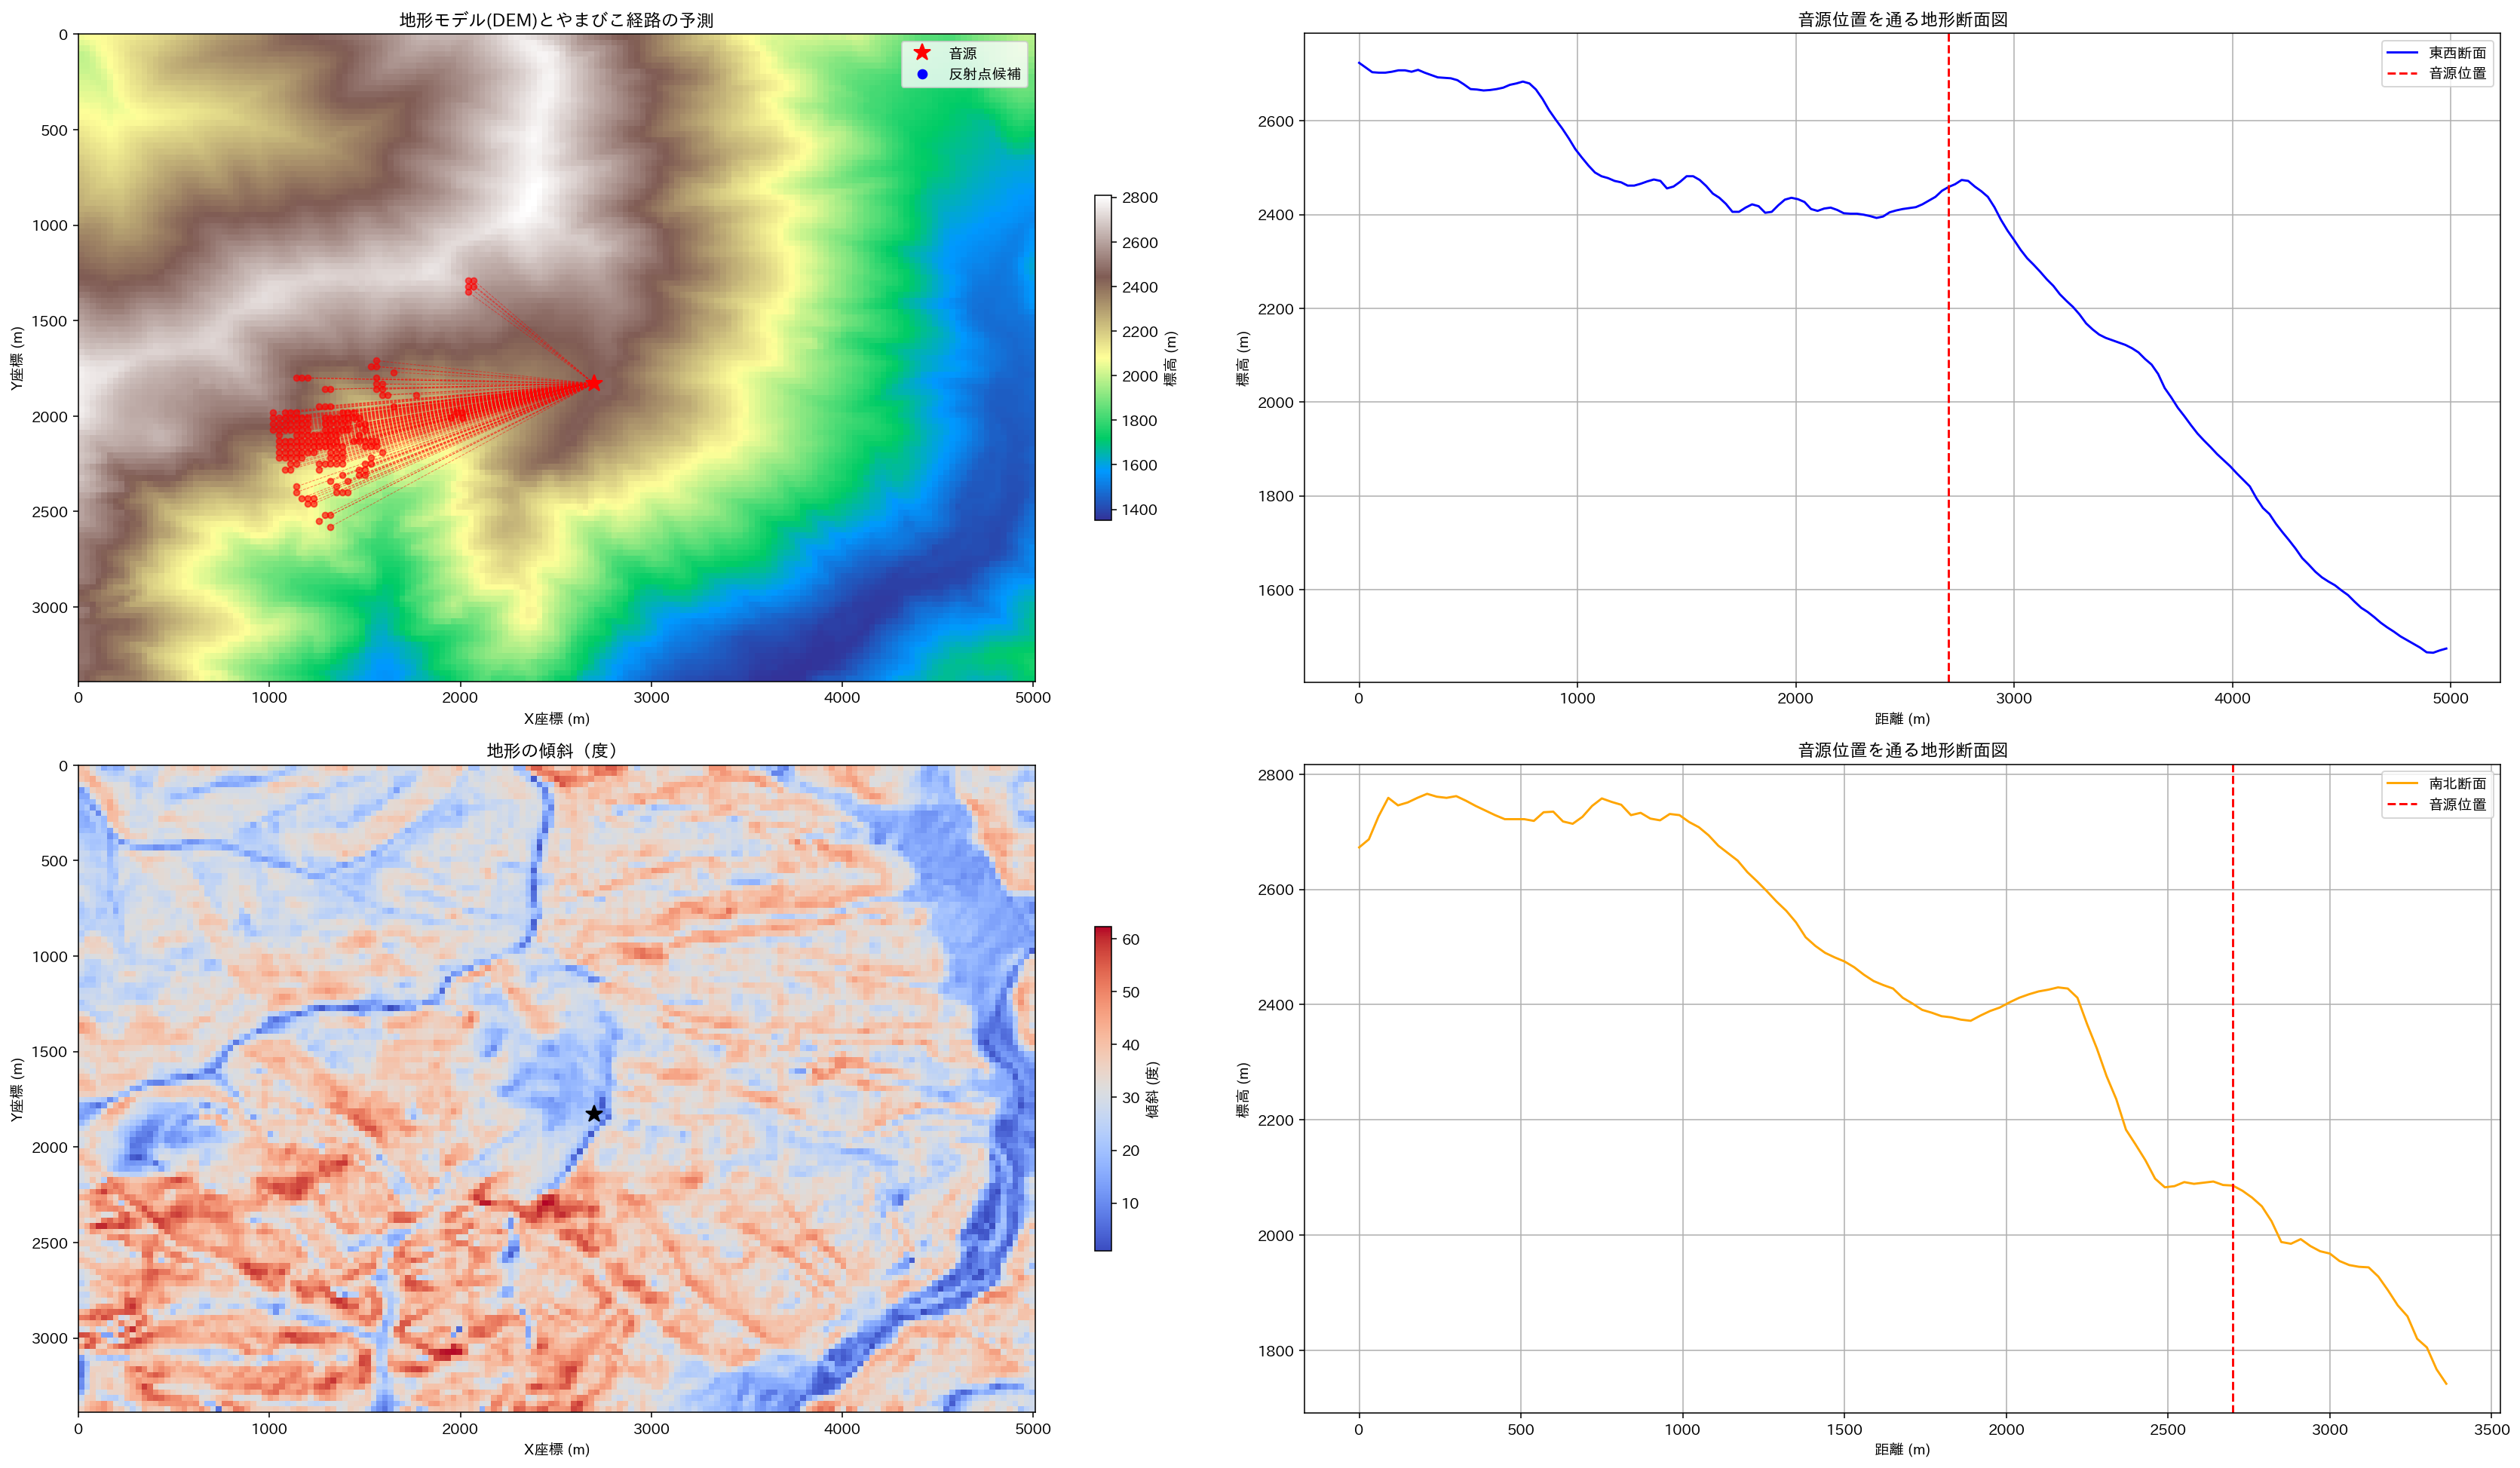

In [75]:
# --- 指定されたDEMファイルの読み込み ---
dem_data = tifffile.imread(PATH_DEM)
cell_dim = 30 # AW3D 30 # 30m解像度


# --- シミュレーション条件 ---
pixel_x, pixel_y = target_point.pixel_x, target_point.pixel_y
source_x, source_y = pixel_x * cell_dim, pixel_y * cell_dim
print(f"音源位置: ({source_x}, {source_y}) (標高: {target_point.dem} m)")


# --- シミュレーションの実行 ---
echoes, slopes = simulate_echo(
    dem_data, 
    source_pos=(pixel_y, pixel_x),  
    cell_size=cell_dim,
    max_angle=80,  # 反射面の傾斜方位の許容角度
)

# --- 結果の表示 ---
if echoes:
    print(f"\n{len(echoes)}個のやまびこの可能性を検出しました：")
    # 距離が近い順にソートして表示
    for echo in sorted(echoes, key=lambda x: x['distance_m']):
        print(
            f"  - 反射位置: {echo['position']}, "
            f"距離: {echo['distance_m']:.1f} m, "
            f"遅延時間: {echo['delay_s']:.2f} 秒, "
            f"斜面傾斜: {echo['slope_deg']:.1f}度"
        )
else:
    print("\nやまびこが聞こえる可能性のある地点は見つかりませんでした。")

# --- 可視化 ---
fig, ax = plt.subplots(2, 2, figsize=(24, 14), facecolor="w", dpi=140, edgecolor="k")

# DEMとやまびこ経路の可視化
grid_size_y, grid_size_x = dem_data.shape
im = ax[0, 0].imshow(dem_data, cmap='terrain', origin='upper', 
                    extent=[0, grid_size_x * cell_dim, grid_size_y * cell_dim, 0])
ax[0, 0].set_title("地形モデル(DEM)とやまびこ経路の予測")

ax[0, 0].plot(source_x, source_y, '*', markersize=12, label='音源', color='red')

# 検出されたやまびこ候補を描画
for echo in echoes:
    target_x, target_y = echo['position'][1] * cell_dim, echo['position'][0] * cell_dim
    ax[0, 0].plot(target_x, target_y, 'ro', markersize=4, alpha=0.6)
    ax[0, 0].plot([source_x, target_x], [source_y, target_y], 'r--', linewidth=0.5, alpha=0.5)

# 凡例用のダミープロット
if echoes:
    ax[0, 0].plot([], [], 'bo', markersize=6, label='反射点候補')

ax[0, 0].legend()
ax[0, 0].set_xlabel("X座標 (m)")
ax[0, 0].set_ylabel("Y座標 (m)")
fig.colorbar(im, ax=ax[0, 0], label='標高 (m)', shrink=0.5)

im = ax[1, 0].imshow(slopes, cmap='coolwarm', origin='upper', 
                    extent=[0, grid_size_x * cell_dim, grid_size_y * cell_dim, 0])
ax[1, 0].plot(source_x, source_y, '*', markersize=12, label='音源', color='black')
ax[1, 0].set_title("地形の傾斜（度）")
ax[1, 0].set_xlabel("X座標 (m)")
ax[1, 0].set_ylabel("Y座標 (m)")
fig.colorbar(im, ax=ax[1, 0], label='傾斜 (度)', shrink=0.5)

# 音源を通る断面図の可視化
ax[0, 1].plot(np.arange(grid_size_x) * cell_dim, dem_data[grid_size_y // 2, :], 
            label='東西断面', color='b')
ax[0, 1].axvline(x=source_x, color='r', linestyle='--', label='音源位置')
ax[0, 1].set_title("音源位置を通る地形断面図")
ax[0, 1].set_xlabel("距離 (m)")
ax[0, 1].set_ylabel("標高 (m)")
ax[0, 1].legend()
ax[0, 1].grid(True)

# 音源を通る断面図の可視化
ax[1, 1].plot(np.arange(grid_size_y) * cell_dim, dem_data[:, grid_size_x // 2], 
            label='南北断面', color='orange')
ax[1, 1].axvline(x=source_x, color='r', linestyle='--', label='音源位置')
ax[1, 1].set_title("音源位置を通る地形断面図")
ax[1, 1].set_xlabel("距離 (m)")
ax[1, 1].set_ylabel("標高 (m)")
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'kasagadake_echo_simulation.png'), bbox_inches='tight')
plt.show();
plt.clf();plt.close('all')

## 方角と経過時間

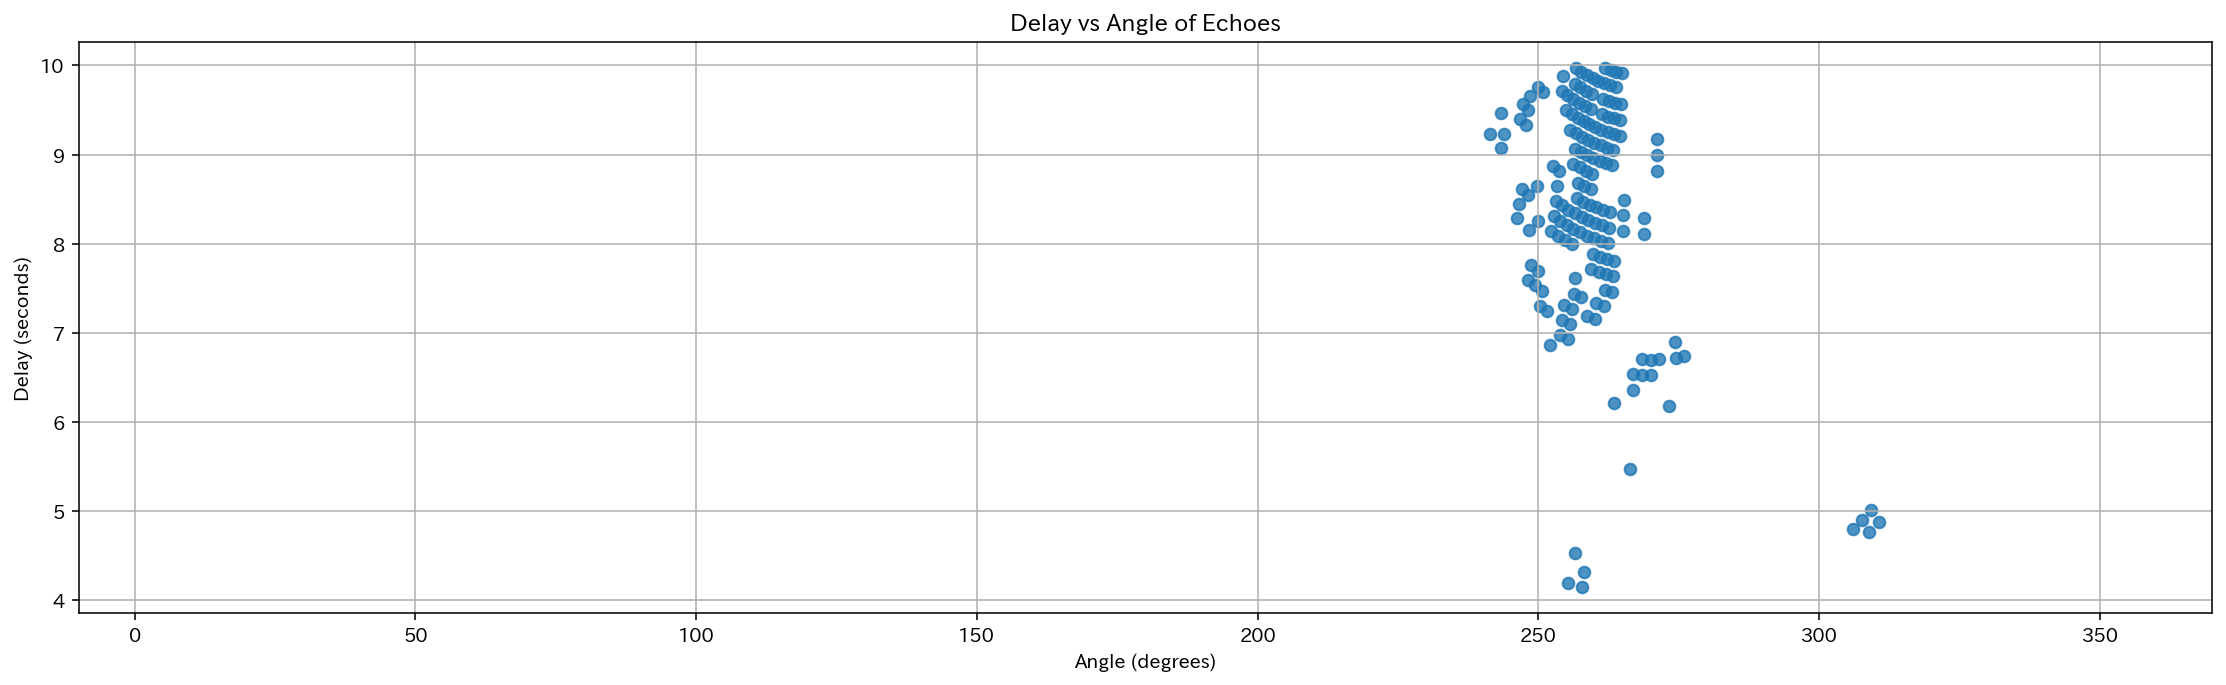

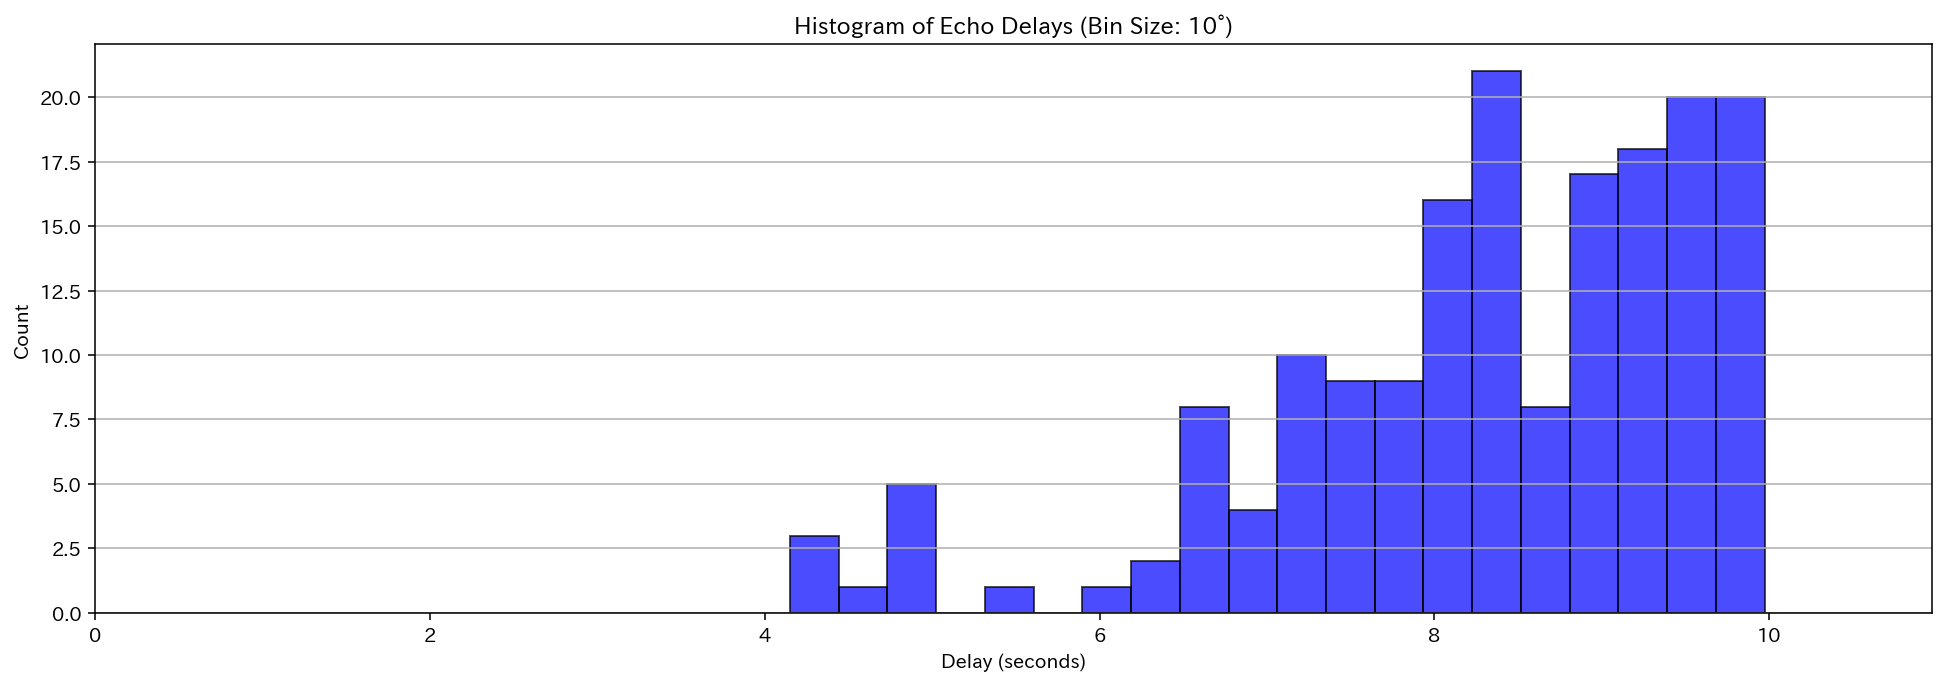

In [76]:
df = pd.DataFrame({
    "position_x": [echo['position'][1] for echo in echoes],
    "position_y": [echo['position'][0] for echo in echoes],
    "source_x": source_x / cell_dim,
    "source_y": source_y / cell_dim,
    "distance_m": [echo['distance_m'] for echo in echoes],
    "delay_s": [echo['delay_s'] for echo in echoes],
    "slope_deg": [echo['slope_deg'] for echo in echoes]
})

# 反射波の帰ってきた方向xyを得る
df['direction_x'] = - df['position_x'] + df['source_x']
df['direction_y'] = - df['position_y'] + df['source_y']

# angle xy
df['angle_xy'] = np.arctan2(df['direction_y'], df['direction_x']) * 180 / np.pi
df['angle_xy'] = (df['angle_xy'] - 90) % 360

df.index.name = "sample_idx"            # 行番号＝時系列順のインデックス
BIN_SIZE = 10                           # お好みで 5, 15, 30 などに変更可
df["angle_bin"] = (df["angle_xy"] // BIN_SIZE * BIN_SIZE).astype(int)
table = df.pivot_table(index="sample_idx",
                       columns="angle_bin",
                       values="delay_s")
# plot delay vs angle
plt.figure(figsize=(16, 5), dpi=140, facecolor="w", edgecolor="k")
plt.scatter(df['angle_xy'] , df['delay_s'], alpha=0.8)
plt.title('Delay vs Angle of Echoes')
plt.xlabel('Angle (degrees)')
plt.ylabel('Delay (seconds)')
plt.xlim(-10, 370)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'delay_vs_angle.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

plt.figure(figsize=(14, 5), dpi=140, facecolor="w", edgecolor="k")
plt.hist(df['delay_s'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title(f'Histogram of Echo Delays (Bin Size: {BIN_SIZE}°)')
plt.xlabel('Delay (seconds)')
plt.ylabel('Count')
plt.xlim(0, df['delay_s'].max() + 1)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'echo_delay_histogram.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

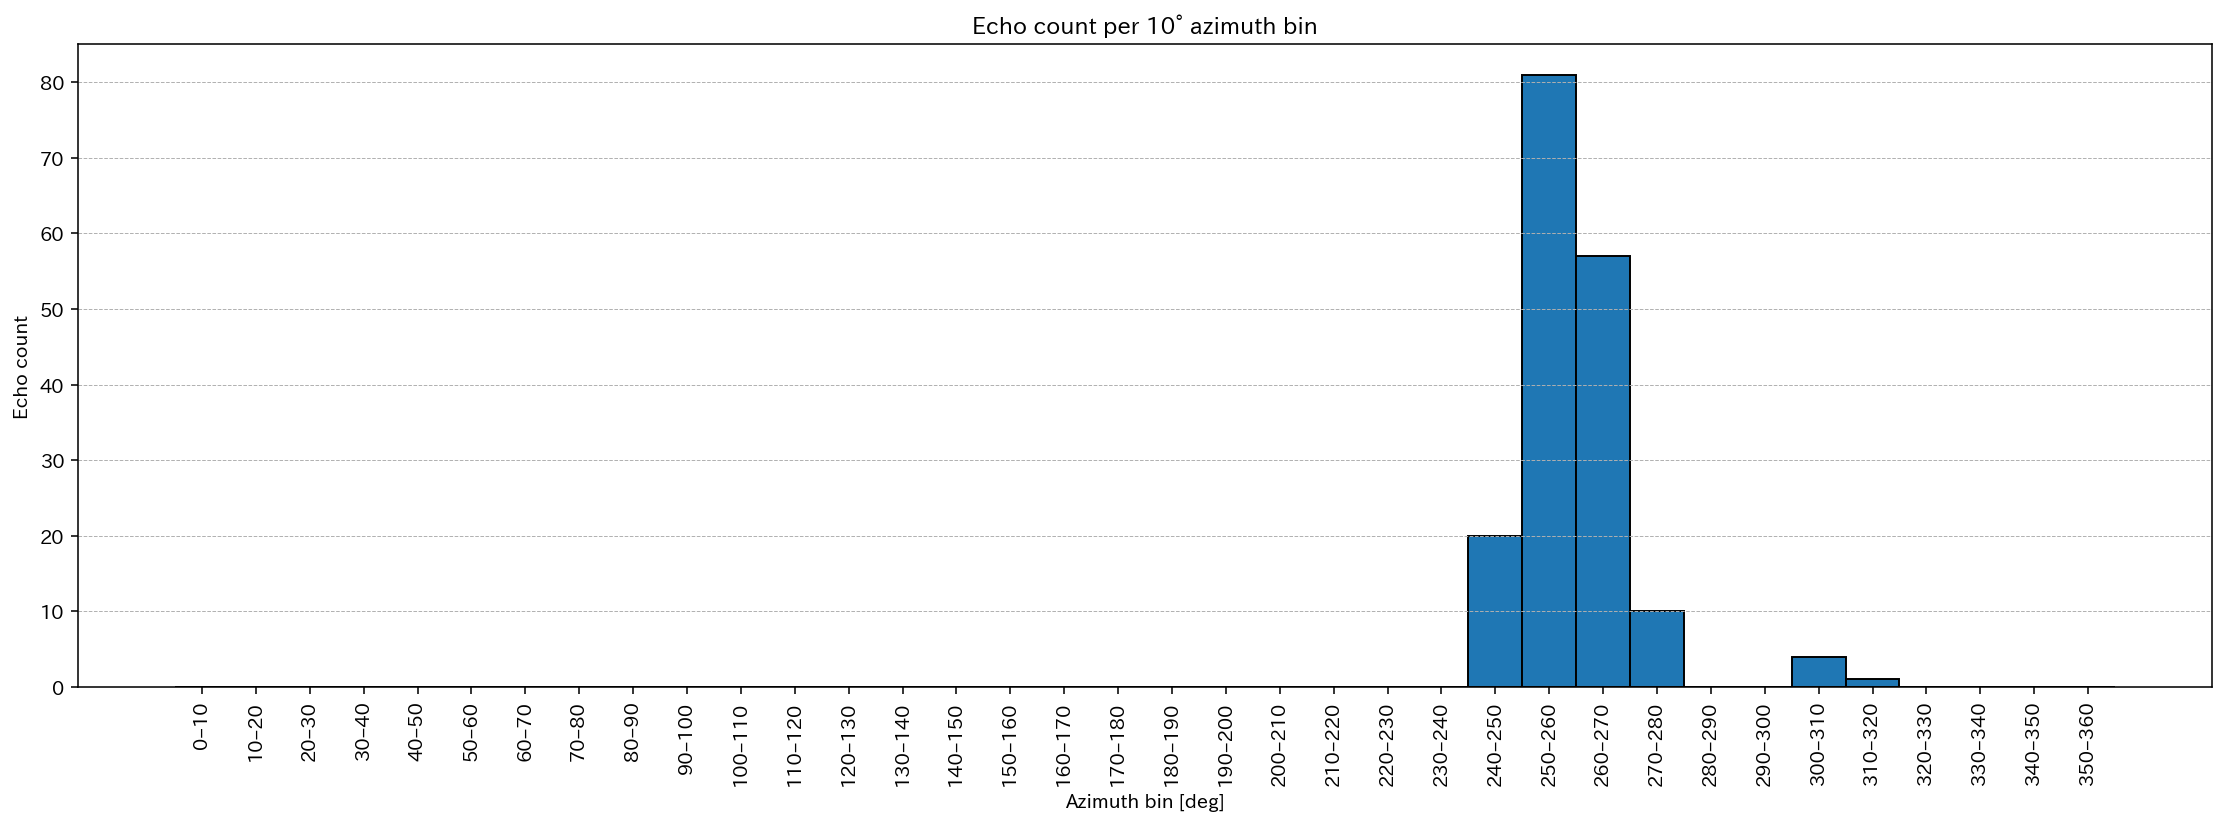

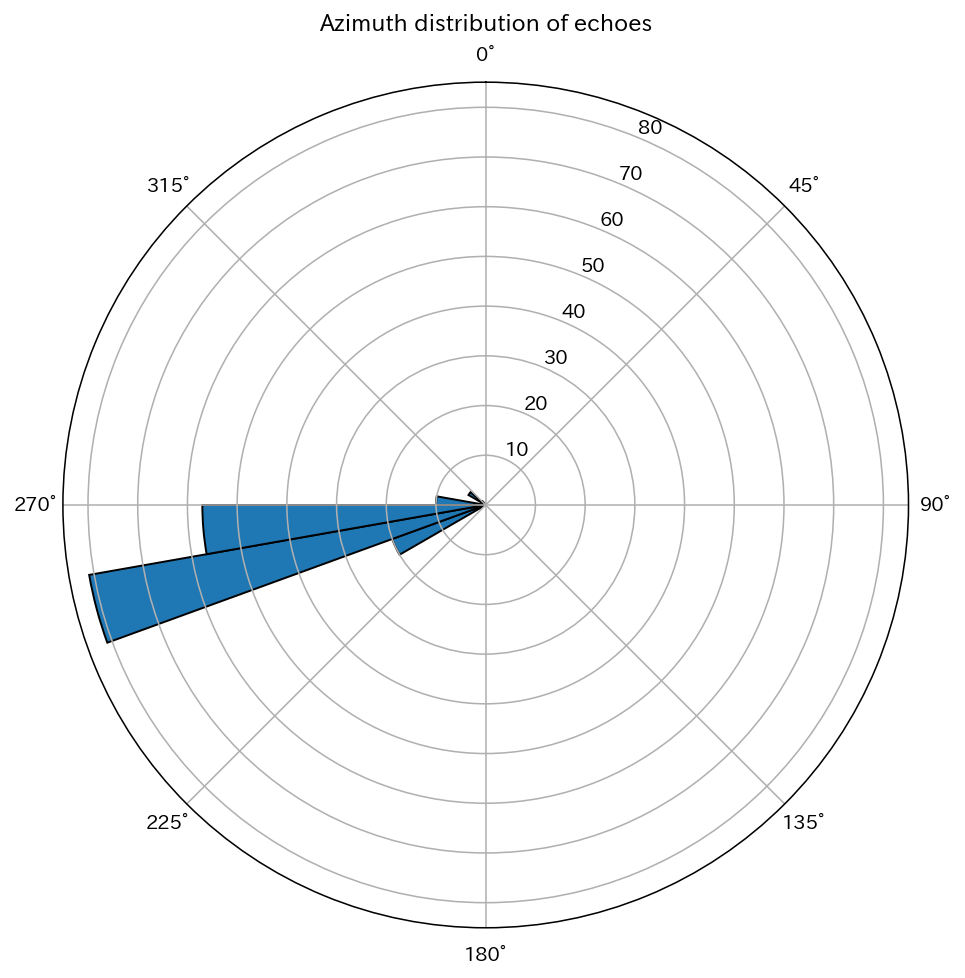

In [77]:
bins = np.arange(0, 360 + BIN_SIZE, BIN_SIZE)
hist, edges = np.histogram(df["angle_xy"], bins=bins)
plt.figure(figsize=(16, 6), dpi=140, facecolor="w", edgecolor="k")
plt.bar(edges[:-1], hist,
        width=BIN_SIZE,
        align="edge",
        edgecolor="black")
plt.xlabel("Azimuth bin [deg]")
plt.ylabel("Echo count")
plt.title(f"Echo count per {BIN_SIZE}° azimuth bin")
plt.xticks(edges[:-1] + BIN_SIZE / 2,
           [f"{int(e)}–{int(e + BIN_SIZE)}" for e in edges[:-1]],
           rotation=90)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'echo_azimuth_histogram.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

theta = np.deg2rad(edges[:-1])
width = np.deg2rad(BIN_SIZE)
fig = plt.figure(figsize=(14, 8), dpi=140, facecolor="w", edgecolor="k")
ax = fig.add_subplot(111, projection="polar")
ax.bar(theta,
       hist,
       width=width,
       bottom=0,
       align="edge",
       edgecolor="black")
ax.set_theta_zero_location("N")   # 0° = 北
ax.set_theta_direction(-1)        # 時計回り
ax.set_title("Azimuth distribution of echoes", va="bottom")
plt.savefig(os.path.join(PATH_OUTPUT, 'echo_azimuth_histogram_polar.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

## クラスター解析

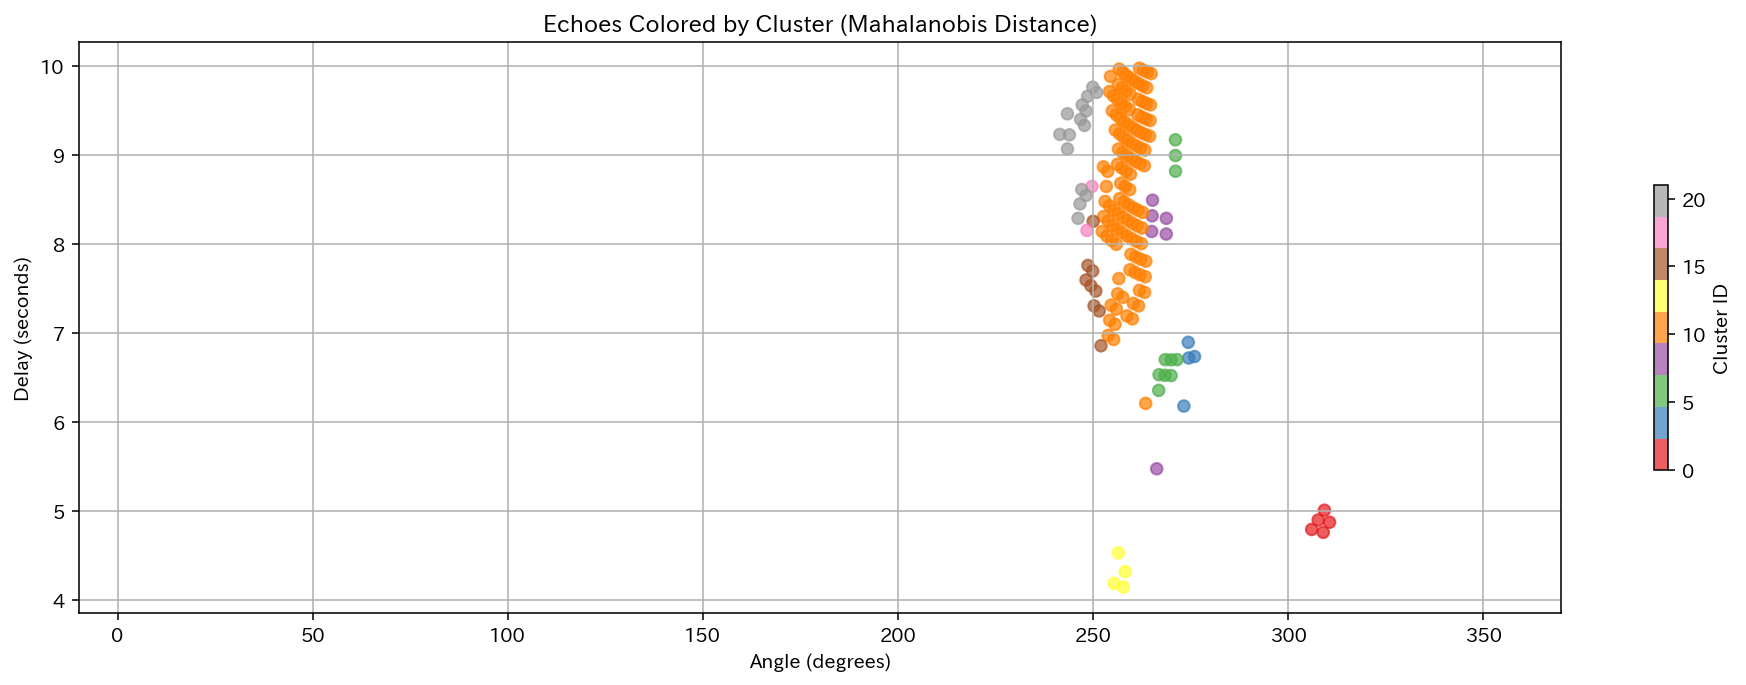

In [78]:
# 特徴量行列
X = df[['angle_xy', 'delay_s']].to_numpy()

# 共分散とその逆行列（特異な場合に備えて pinv 推奨）
cov = np.cov(X, rowvar=False)
VI = np.linalg.pinv(cov)  # np.linalg.inv でもよいが数値安定性のため pinv

# eps の設定目安：
eps = 0.2  # 必要に応じて調整

db = DBSCAN(
    eps=eps,
    min_samples=1,
    metric='mahalanobis',
    metric_params={'VI': VI}
)
labels = db.fit_predict(X)
df['cluster'] = labels

plt.figure(figsize=(14, 5), dpi=140, facecolor="w", edgecolor="k")
scatter = plt.scatter(df['angle_xy'], df['delay_s'], c=df['cluster'], cmap='Set1', alpha=0.7)
plt.title('Echoes Colored by Cluster (Mahalanobis Distance)')
plt.xlabel('Angle (degrees)')
plt.ylabel('Delay (seconds)')
plt.xlim(-10, 370)
plt.colorbar(scatter, label='Cluster ID',shrink=0.5)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'echo_clusters.png'), bbox_inches='tight')    
plt.show()


## ジオコード

In [79]:
def pixel_to_lonlat(src, x_pix: int, y_pix: int):
    """
    ピクセル座標 (x_pix, y_pix) → 経度・緯度 (lon, lat) へ変換するヘルパ。
    Rasterio では (row, col) = (y, x) の順なので注意。
    """
    # GeoTIFF の CRS で座標を取得
    lon_src, lat_src = src.xy(row=y_pix, col=x_pix, offset="center")

    # 必要なら EPSG:4326 に再投影
    if src.crs.to_epsg() != 4326:
        lon_dst, lat_dst = reproject_pts(
            src.crs, "EPSG:4326", [lon_src], [lat_src]
        )
        lon_src, lat_src = lon_dst[0], lat_dst[0]

    return lon_src, lat_src

def circle_polygon(
    lon: float,
    lat: float,
    radius_m: float = 30.0,
    n_vertices: int = 64,
):
    """
    半径[m]でバッファした円を多角形近似し、GeoJSON Polygon座標を返します。
    戻り値: [ [ [lon1,lat1], ..., [lon1,lat1] ] ]
    """
    cx, cy = (lon, lat)

    ring = []
    for i in range(n_vertices):
        th = 2 * math.pi * i / n_vertices
        x = cx + radius_m * math.cos(th)
        y = cy + radius_m * math.sin(th)
        lon_i, lat_i = (x, y)
        ring.append([lon_i, lat_i])

    ring.append(ring[0])
    return [ring]

In [80]:
features = []
radius_m: float = 30.0 * 1e-5

with rasterio.open(PATH_DEM) as src:

    row = df.iloc[0]
    x_pix, y_pix = row['source_x'], row['source_y']
    lon, lat = pixel_to_lonlat(src, x_pix, y_pix)

    # 円ポリゴンのGeoJSON形式
    features.append(
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": circle_polygon(lon, lat, radius_m),
            },
            "properties": {
                "pixel_x": x_pix,
                "pixel_y": y_pix,
                "name": "Kasagadake Echo Point",
                "radius_m": radius_m,
            },
        }
    )
    
    
    
    for i, (x_pix, y_pix, x_pos, y_pos, delay_s, angle_xy, clus) in enumerate(
            zip(df['source_x'], df['source_y'], df['position_x'], df['position_y'],
                df['delay_s'], df['angle_xy'], df['cluster'])):
        lon_src, lat_src = pixel_to_lonlat(src, x_pix, y_pix)
        lon_pos, lat_pos = pixel_to_lonlat(src, x_pos, y_pos)
        
        sec_str = f"{delay_s:.1f}秒"
        
        features.append(
            # pointのGeoJSON形式
            {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [lon_pos, lat_pos],  # GeoJSON は (lon, lat) 順
                    
                },
                "properties": {
                    "pixel_x": x_pos,
                    "pixel_y": y_pos,
                    "name": "Reflection Point",
                    "cluster": clus,
                    "delay_s": delay_s,
                    "delay_str": sec_str,
                    "angle_xy": angle_xy,
                },
            })
        
        # 反射位置の座標
        features.append(
            # position -> source の LineString
            {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": [
                        [lon_src, lat_src],  # 音源位置
                        [lon_pos, lat_pos]   # 反射位置
                    ]
                },
                "properties": {
                    "source_x": x_pix,
                    "source_y": y_pix,
                    "position_x": x_pos,
                    "position_y": y_pos,
                    "delay_s": delay_s,
                    "delay_str": sec_str,
                    "angle_xy": angle_xy,
                    "cluster": clus,
                    "name": "Echo Trace",
                }
            },
            
        )

fc = {"type": "FeatureCollection", "features": features}

# 保存
out_path = os.path.join(PATH_OUTPUT, 'kasagadake_echoes.geojson')
out_path = Path(out_path)
out_path.write_text(json.dumps(fc, ensure_ascii=False, indent=2))
print(f"✅  GeoJSON 保存完了: {out_path.resolve()}")
df.to_csv(os.path.join(PATH_OUTPUT, 'kasagadake_echoes.csv'), index=False)
print(f"✅  CSV 保存完了: {os.path.join(PATH_OUTPUT, 'kasagadake_echoes.csv')}")

✅  GeoJSON 保存完了: /Users/syu/src/git/my-example/yamabiko/src/output/006/kasagadake_echoes.geojson
✅  CSV 保存完了: output/006/kasagadake_echoes.csv


## 伝搬シミュレーション

Animating:   0%|                              | 0/228 [00:00<?, ?it/s]/var/folders/vg/3f79b2x54mz7ny6lbm1bfhrw0000gn/T/ipykernel_3779/2806899563.py:85: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(x, y)
Animating: 100%|████████████████████| 228/228 [00:39<00:00,  5.72it/s]


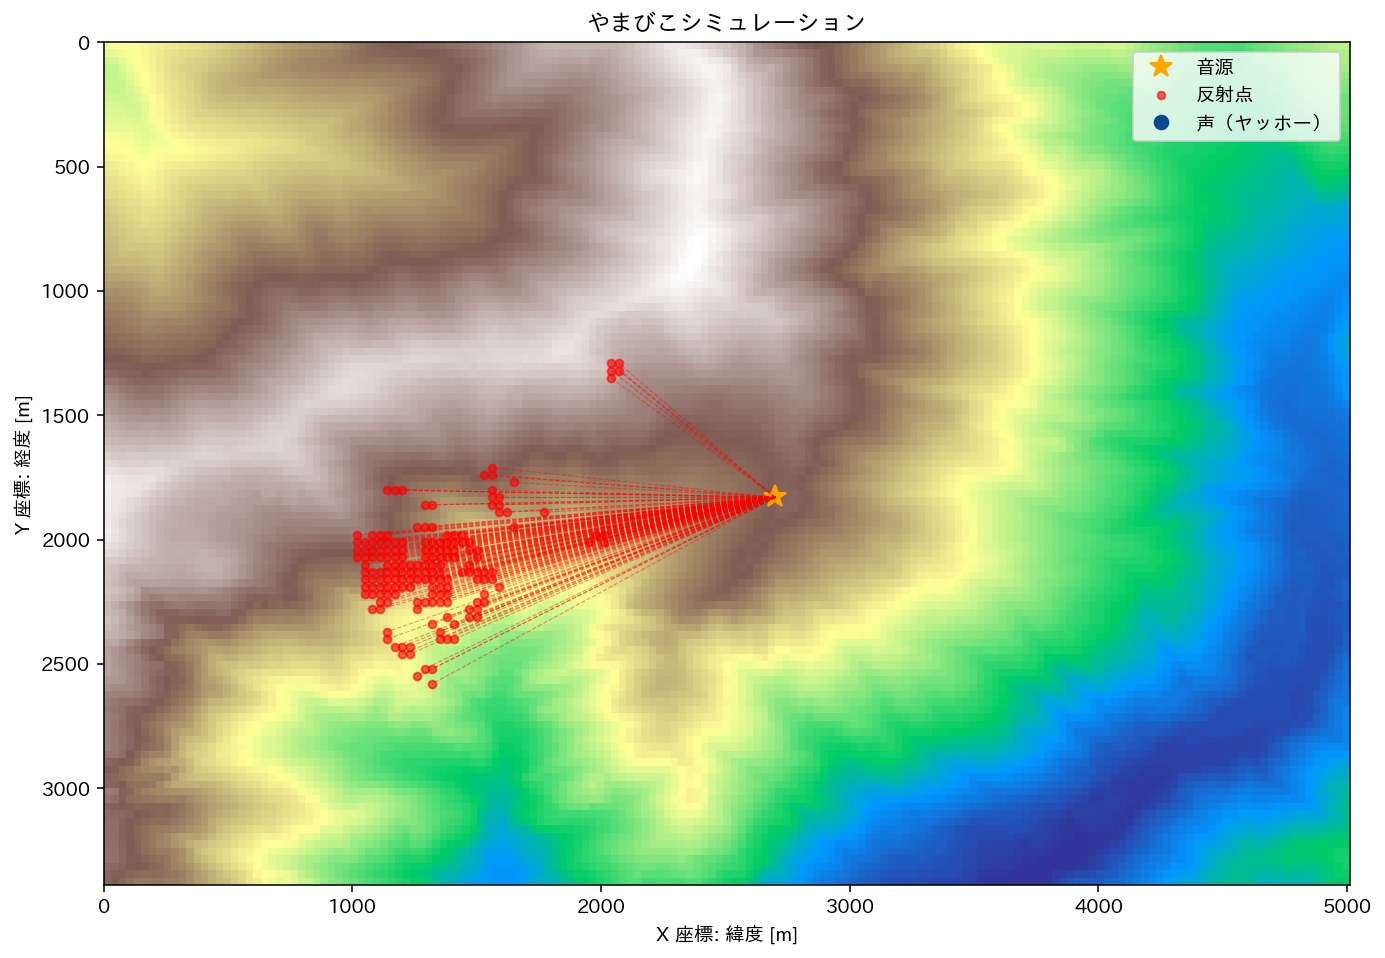

In [81]:
# 音源の位置（m）
src_x, src_y = df.loc[0, ["source_x", "source_y"]]
src_x *= cell_dim
src_y *= cell_dim

# 反射点の位置（m）
tgt_xy_m = np.column_stack([
    df["position_x"].values * cell_dim,
    df["position_y"].values * cell_dim,
])

# pixel 差分
dx_pix = (tgt_xy_m[:, 0] - src_x) / cell_dim
dy_pix = (tgt_xy_m[:, 1] - src_y) / cell_dim

# 速度 (m/s): 斜めなら √2 * 30?
speed_mps = np.where(
    (dx_pix != 0) & (dy_pix != 0),
    # cell_dim * np.sqrt(2),         # 42.4264
    cell_dim,                       # 30
    cell_dim                        # 30
)

# 片道距離と所要時間
dist_m        = np.hypot(tgt_xy_m[:, 0] - src_x, tgt_xy_m[:, 1] - src_y)
time_one_leg  = dist_m / speed_mps          # [s] 片道
time_round    = 2 * time_one_leg            # [s] 往復

# ------------------------------
# アニメーション設定
# ------------------------------
fps        = 2                          # 描画フレームレート
dt         = 1.0 / fps                 # 1フレームの時間 [s]
t_max      = time_round.max()            # 最長の往復時間
frames_tot = int(np.ceil(t_max / dt)) + 1


fig, ax = plt.subplots(figsize=(10, 8), dpi=140, facecolor="w")
gs_y, gs_x = dem_data.shape
ax.imshow(
    dem_data, cmap="terrain", origin="upper",
    extent=[0, gs_x * cell_dim, gs_y * cell_dim, 0],
)
ax.set_title("やまびこシミュレーション")
ax.set_xlabel("X 座標: 緯度 [m]")
ax.set_ylabel("Y 座標: 経度 [m]")
ax.plot(src_x, src_y, "*", ms=12, color="orange", label="音源")
for i, (tx, ty) in enumerate(tgt_xy_m):
    if i == 0:
        ax.plot(tx, ty, "ro", ms=4, alpha=0.6, label="反射点")
    else:
        ax.plot(tx, ty, "ro", ms=4, alpha=0.6)                       # 反射点
    ax.plot([src_x, tx], [src_y, ty], "r--", lw=0.6, alpha=0.4)  # 経路

# 動く点を反射点の数だけ生成
color_range = np.linspace(0.3, 0.9, len(tgt_xy_m))  # 最後の点はラベル用
blue_colors = plt.cm.Blues(color_range)
moving_dots = [
    ax.plot([], [], "o", ms=7, color=blue_colors[i], alpha=0.6)[0] for i in range(len(tgt_xy_m)-1)
] + [
    ax.plot([], [], "o", ms=7, color=blue_colors[-1], label="声（ヤッホー）")[0]
    ]  # 最後の点はラベル用
ax.legend()
pbar = tqdm(total=frames_tot, desc="Animating", ncols=70)

def init():
    for dot in moving_dots:
        dot.set_data([], [])
    return moving_dots

def update(frame):
    t_now = frame * dt  # 経過秒

    for i, dot in enumerate(moving_dots):
        T = time_one_leg[i]

        # 0‥T : forward、T‥2T : backward、それ以降は停止
        if t_now <= 2 * T:
            if t_now <= T:             # 往路
                tau = t_now / T
            else:                      # 復路
                tau = 2 - t_now / T
            x = src_x + tau * (tgt_xy_m[i, 0] - src_x)
            y = src_y + tau * (tgt_xy_m[i, 1] - src_y)
            dot.set_data(x, y)
        else:
            dot.set_data([], [])       # 座標リセット
            dot.set_visible(False)     # 完全非表示
            
    pbar.update(1)
    if frame == frames_tot - 1:      # 最終フレームでバーを閉じる
        pbar.close()

    return moving_dots

ani = FuncAnimation(
    fig, update,
    frames=frames_tot,
    init_func=init,
    blit=True,
    interval=1000 / fps,
    repeat=True,
)
ani.save(
    os.path.join(PATH_OUTPUT, "echoes_all_points.mp4"), 
    writer=FFMpegWriter(fps=30))
plt.tight_layout()
plt.show()

## 空気吸収を考慮したシミュレーション


12個のやまびこの可能性を検出しました：
  - 反射位置: (66, 67), 距離: 706.1 m, 遅延時間: 4.15 秒, 斜面傾斜: 41.0度
  - 反射位置: (67, 67), 距離: 713.1 m, 遅延時間: 4.19 秒, 斜面傾斜: 42.0度
  - 反射位置: (66, 66), 距離: 735.5 m, 遅延時間: 4.32 秒, 斜面傾斜: 42.6度
  - 反射位置: (67, 65), 距離: 771.3 m, 遅延時間: 4.53 秒, 斜面傾斜: 42.5度
  - 反射位置: (44, 69), 距離: 810.6 m, 遅延時間: 4.76 秒, 斜面傾斜: 42.3度
  - 反射位置: (45, 68), 距離: 816.1 m, 遅延時間: 4.80 秒, 斜面傾斜: 46.1度
  - 反射位置: (43, 69), 距離: 829.8 m, 遅延時間: 4.88 秒, 斜面傾斜: 41.6度
  - 反射位置: (44, 68), 距離: 834.1 m, 遅延時間: 4.90 秒, 斜面傾斜: 51.3度
  - 反射位置: (43, 68), 距離: 852.8 m, 遅延時間: 5.01 秒, 斜面傾斜: 47.3度
  - 反射位置: (44, 67), 距離: 858.0 m, 遅延時間: 5.04 秒, 斜面傾斜: 44.7度
  - 反射位置: (57, 61), 距離: 878.2 m, 遅延時間: 5.16 秒, 斜面傾斜: 41.5度
  - 反射位置: (63, 59), 距離: 931.9 m, 遅延時間: 5.48 秒, 斜面傾斜: 42.4度


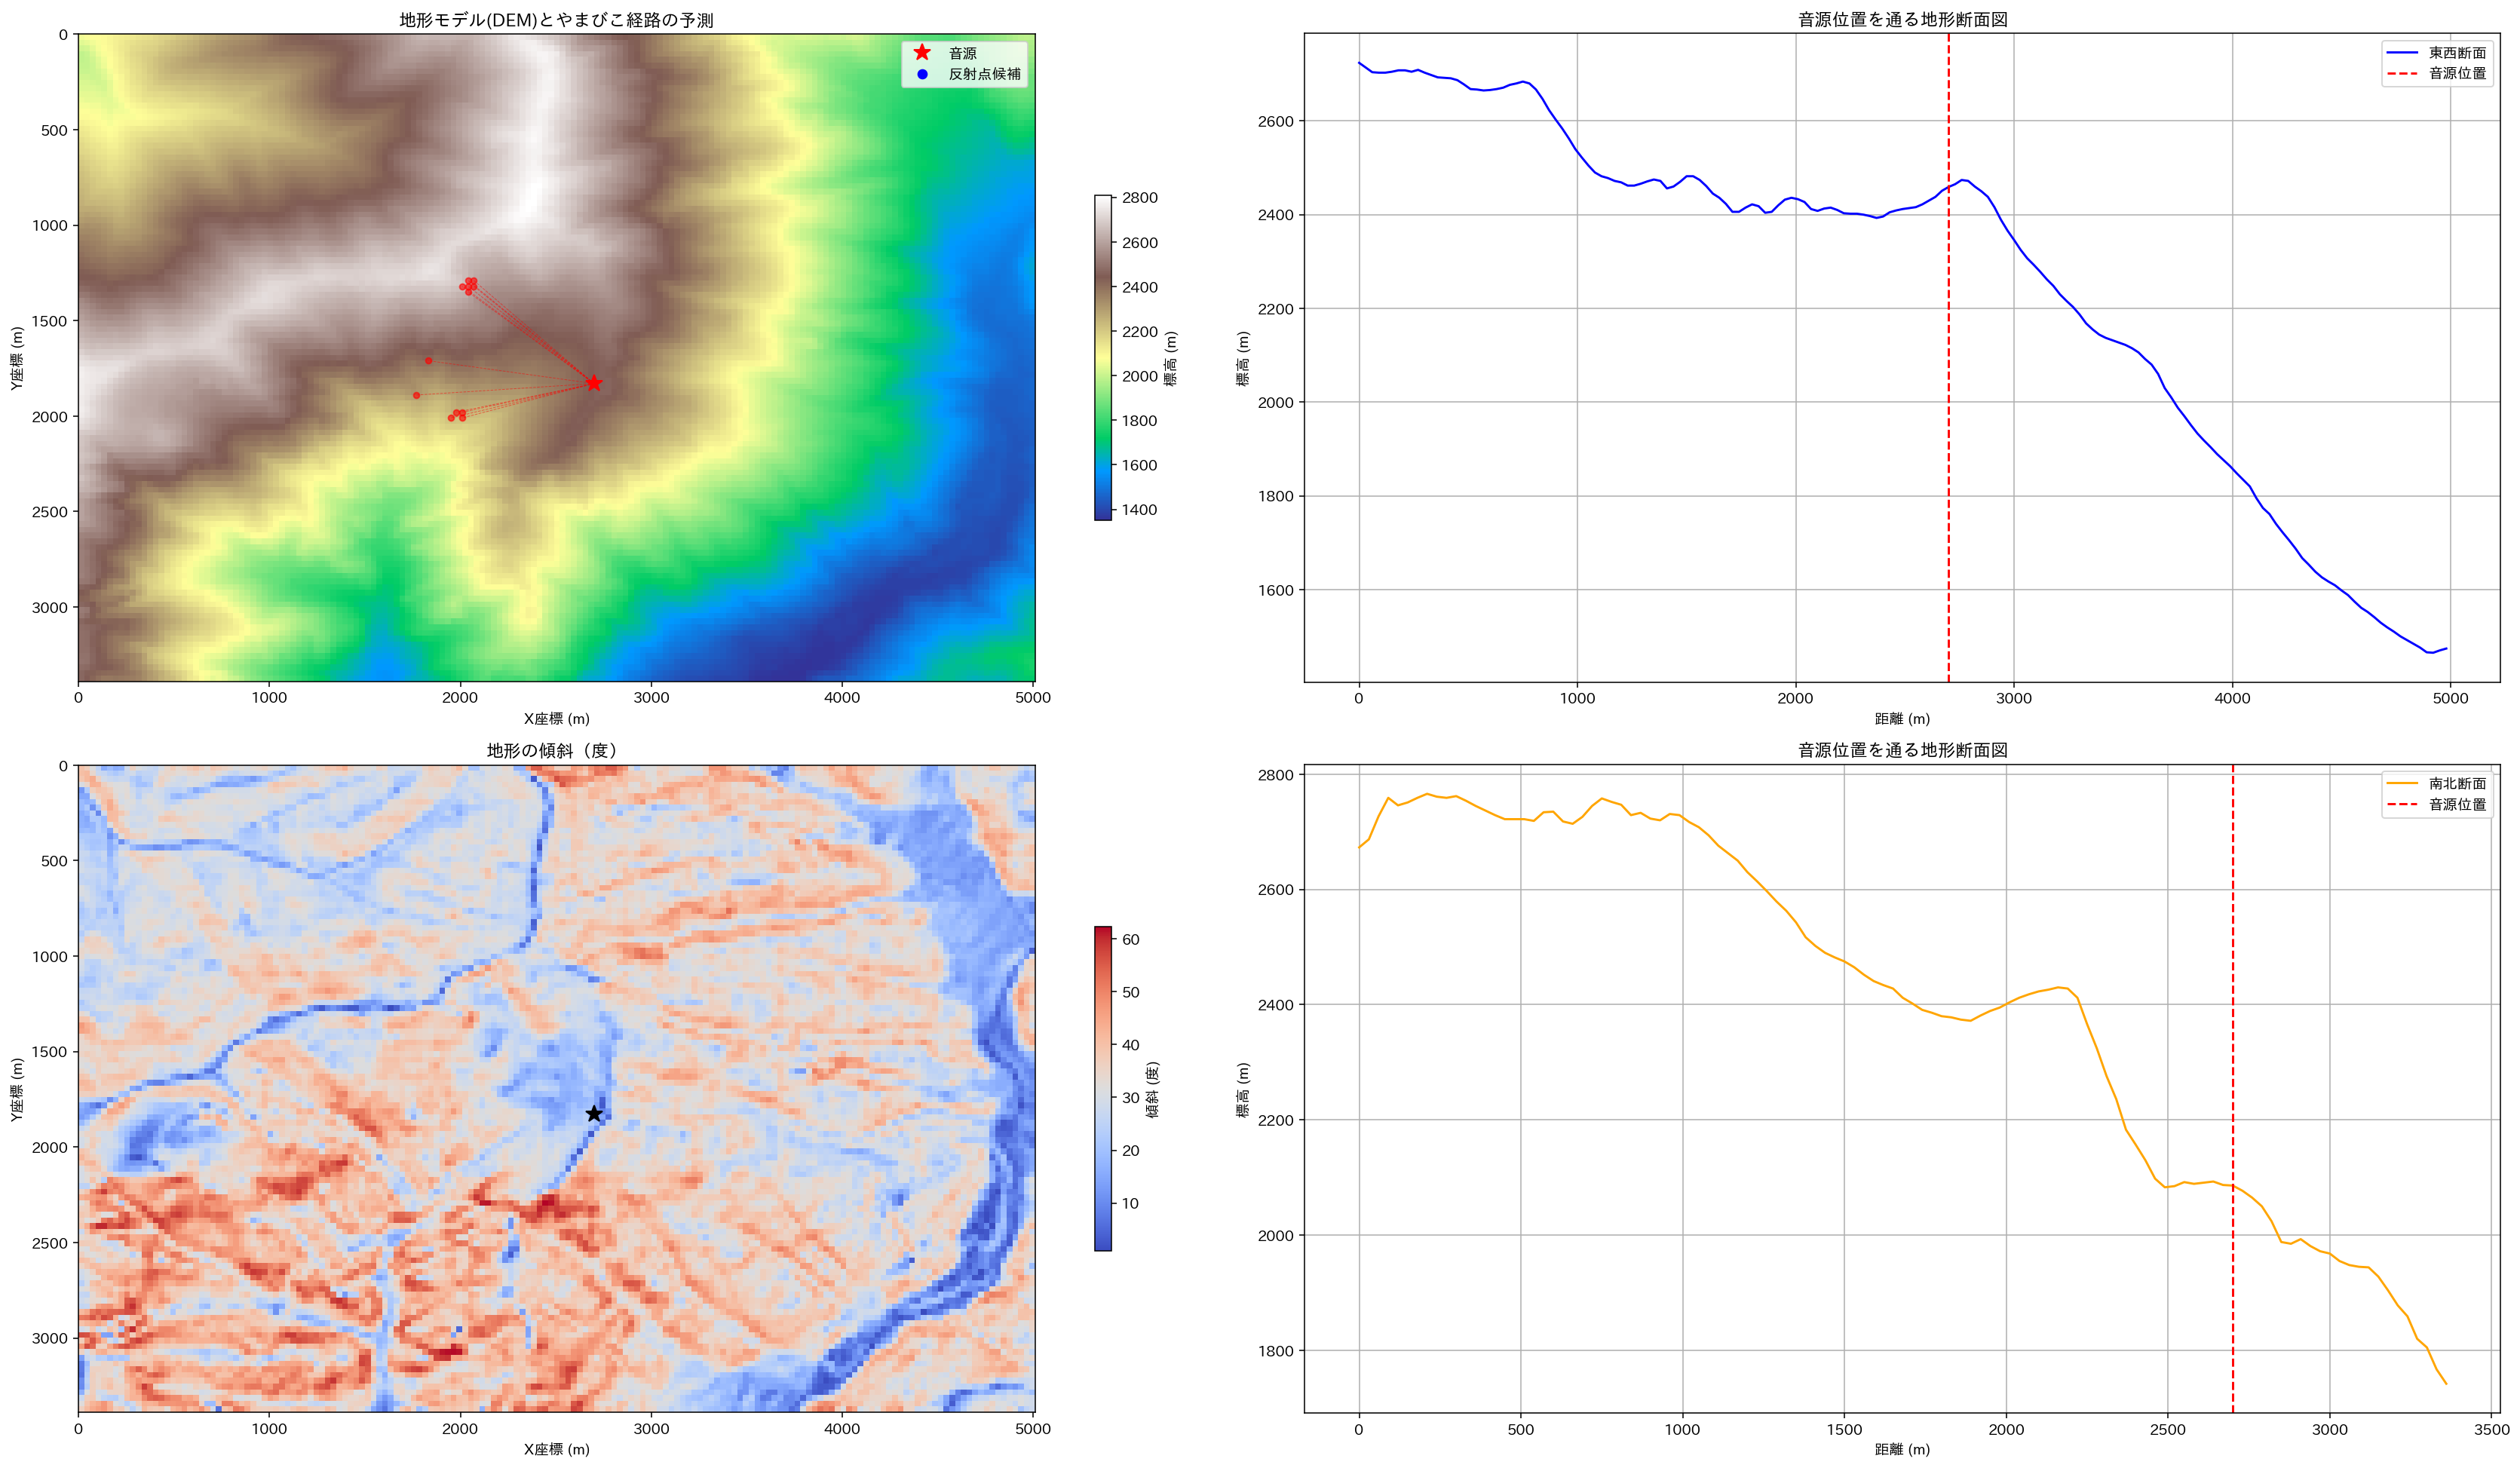

In [82]:
# --- シミュレーションの実行 ---
echoes, slopes = simulate_echo(
    dem_data, 
    source_pos=(pixel_y, pixel_x),  
    cell_size=cell_dim,
    max_distance=1000,
    max_angle=85,
)

# --- 結果の表示 ---
if echoes:
    print(f"\n{len(echoes)}個のやまびこの可能性を検出しました：")
    # 距離が近い順にソートして表示
    for echo in sorted(echoes, key=lambda x: x['distance_m']):
        print(
            f"  - 反射位置: {echo['position']}, "
            f"距離: {echo['distance_m']:.1f} m, "
            f"遅延時間: {echo['delay_s']:.2f} 秒, "
            f"斜面傾斜: {echo['slope_deg']:.1f}度"
        )
else:
    print("\nやまびこが聞こえる可能性のある地点は見つかりませんでした。")

# --- 可視化 ---
fig, ax = plt.subplots(2, 2, figsize=(24, 14), facecolor="w", dpi=140, edgecolor="k")

# DEMとやまびこ経路の可視化
grid_size_y, grid_size_x = dem_data.shape
im = ax[0, 0].imshow(dem_data, cmap='terrain', origin='upper', 
                    extent=[0, grid_size_x * cell_dim, grid_size_y * cell_dim, 0])
ax[0, 0].set_title("地形モデル(DEM)とやまびこ経路の予測")

ax[0, 0].plot(source_x, source_y, '*', markersize=12, label='音源', color='red')

# 検出されたやまびこ候補を描画
for echo in echoes:
    target_x, target_y = echo['position'][1] * cell_dim, echo['position'][0] * cell_dim
    ax[0, 0].plot(target_x, target_y, 'ro', markersize=4, alpha=0.6)
    ax[0, 0].plot([source_x, target_x], [source_y, target_y], 'r--', linewidth=0.5, alpha=0.5)

# 凡例用のダミープロット
if echoes:
    ax[0, 0].plot([], [], 'bo', markersize=6, label='反射点候補')

ax[0, 0].legend()
ax[0, 0].set_xlabel("X座標 (m)")
ax[0, 0].set_ylabel("Y座標 (m)")
fig.colorbar(im, ax=ax[0, 0], label='標高 (m)', shrink=0.5)

im = ax[1, 0].imshow(slopes, cmap='coolwarm', origin='upper', 
                    extent=[0, grid_size_x * cell_dim, grid_size_y * cell_dim, 0])
ax[1, 0].plot(source_x, source_y, '*', markersize=12, label='音源', color='black')
ax[1, 0].set_title("地形の傾斜（度）")
ax[1, 0].set_xlabel("X座標 (m)")
ax[1, 0].set_ylabel("Y座標 (m)")
fig.colorbar(im, ax=ax[1, 0], label='傾斜 (度)', shrink=0.5)

# 音源を通る断面図の可視化
ax[0, 1].plot(np.arange(grid_size_x) * cell_dim, dem_data[grid_size_y // 2, :], 
            label='東西断面', color='b')
ax[0, 1].axvline(x=source_x, color='r', linestyle='--', label='音源位置')
ax[0, 1].set_title("音源位置を通る地形断面図")
ax[0, 1].set_xlabel("距離 (m)")
ax[0, 1].set_ylabel("標高 (m)")
ax[0, 1].legend()
ax[0, 1].grid(True)

# 音源を通る断面図の可視化
ax[1, 1].plot(np.arange(grid_size_y) * cell_dim, dem_data[:, grid_size_x // 2], 
            label='南北断面', color='orange')
ax[1, 1].axvline(x=source_x, color='r', linestyle='--', label='音源位置')
ax[1, 1].set_title("音源位置を通る地形断面図")
ax[1, 1].set_xlabel("距離 (m)")
ax[1, 1].set_ylabel("標高 (m)")
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'kasagadake_echo_simulation_1000m.png'), bbox_inches='tight')
plt.show();
plt.clf();plt.close('all')

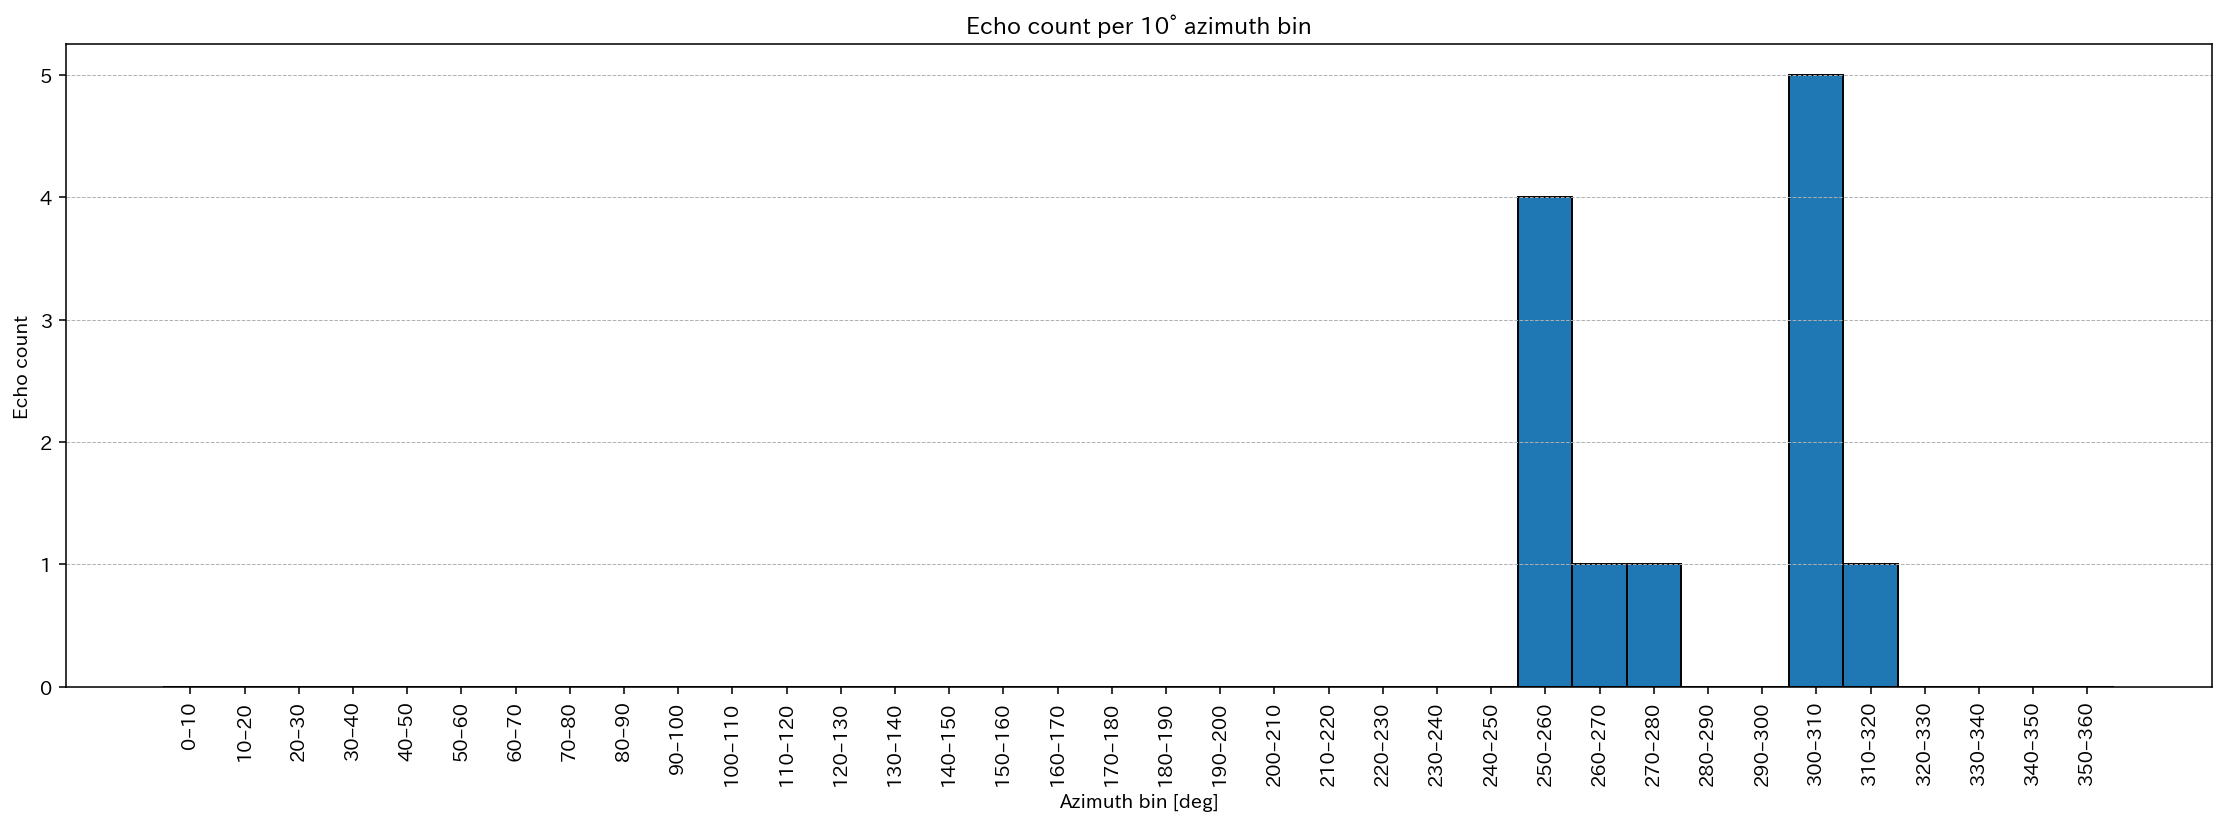

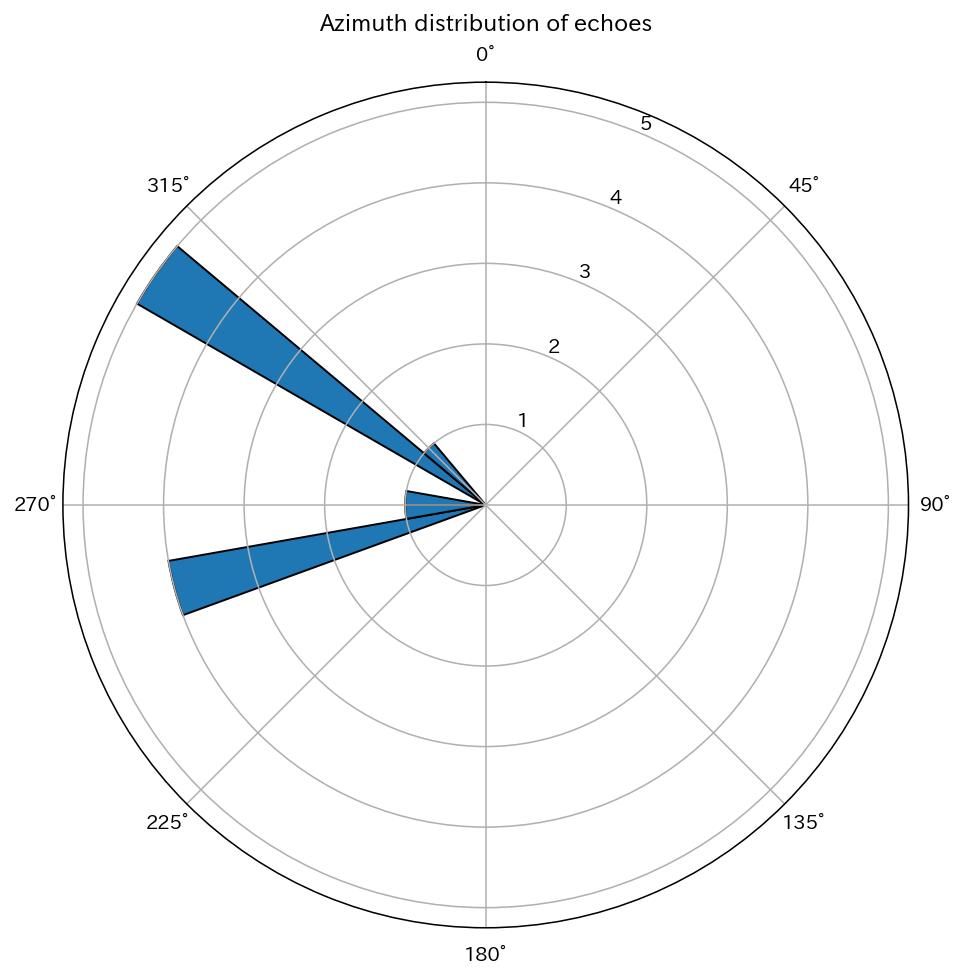

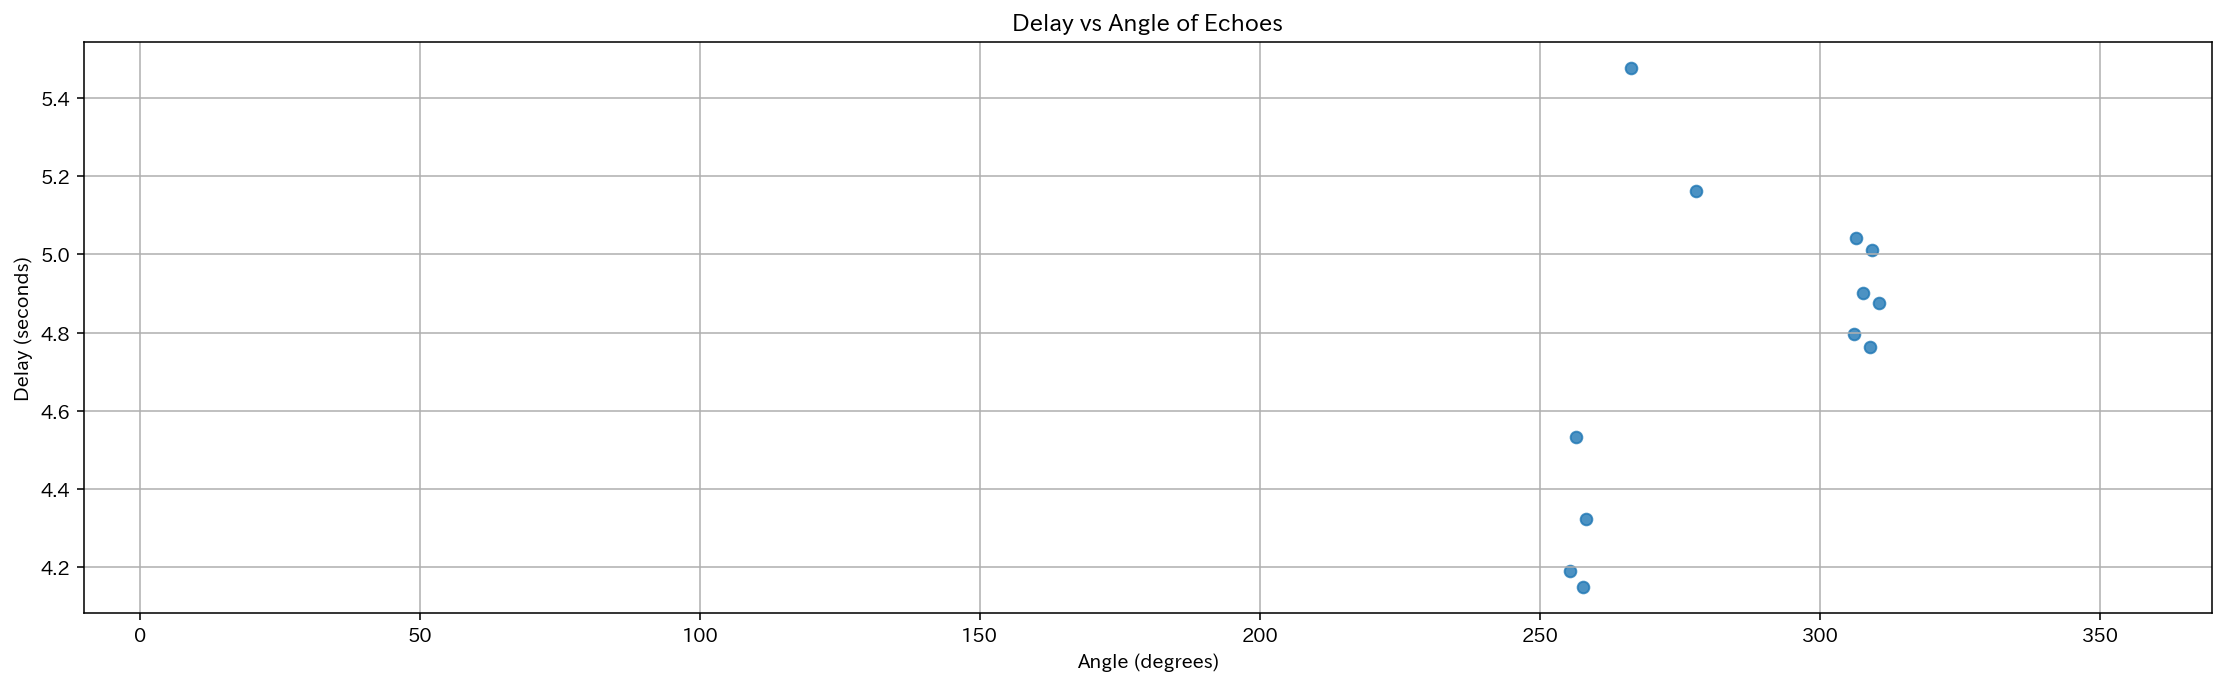

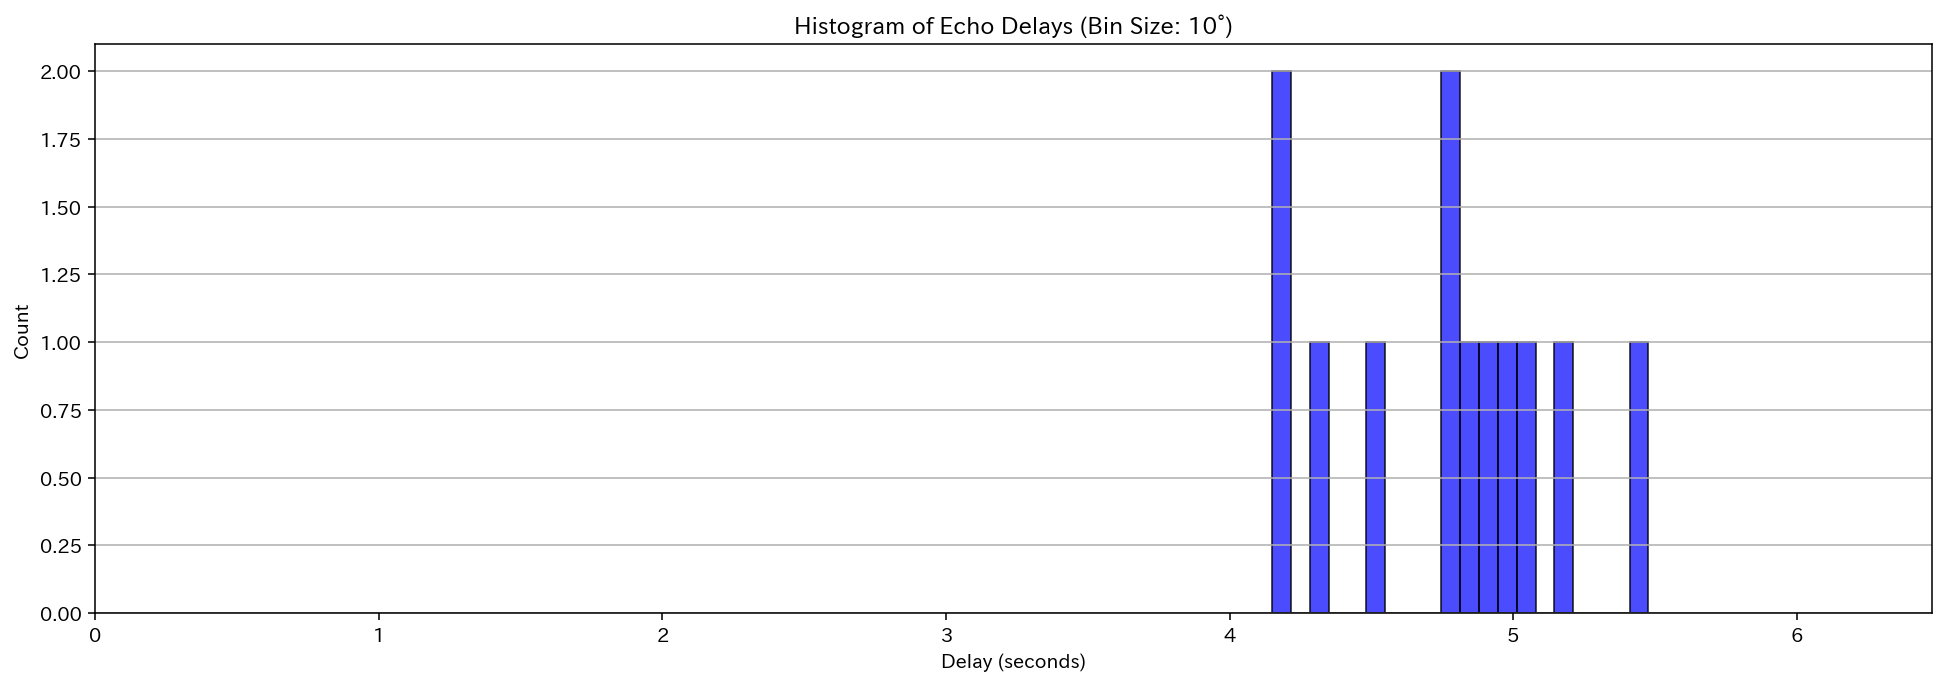

Animating:   0%|                              | 0/126 [00:00<?, ?it/s]/var/folders/vg/3f79b2x54mz7ny6lbm1bfhrw0000gn/T/ipykernel_3779/786532616.py:159: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(x, y)
Animating: 100%|████████████████████| 126/126 [00:08<00:00, 14.73it/s]


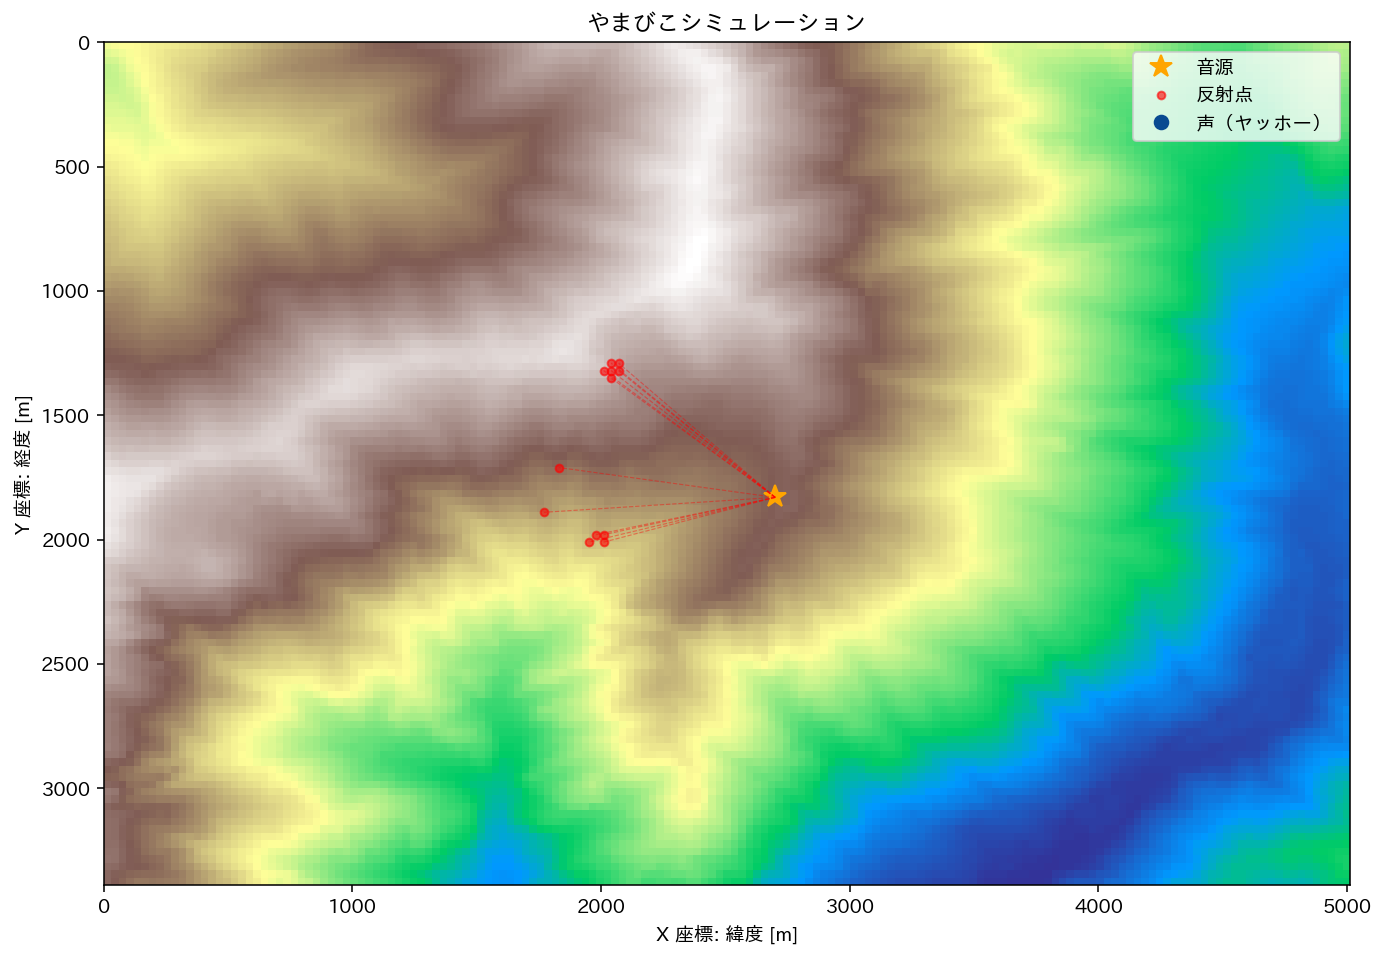

In [83]:
df = pd.DataFrame({
    "position_x": [echo['position'][1] for echo in echoes],
    "position_y": [echo['position'][0] for echo in echoes],
    "source_x": source_x / cell_dim,
    "source_y": source_y / cell_dim,
    "distance_m": [echo['distance_m'] for echo in echoes],
    "delay_s": [echo['delay_s'] for echo in echoes],
    "slope_deg": [echo['slope_deg'] for echo in echoes]
})

# 反射波の帰ってきた方向xyを得る
df['direction_x'] = - df['position_x'] + df['source_x']
df['direction_y'] = - df['position_y'] + df['source_y']

# angle xy
df['angle_xy'] = np.arctan2(df['direction_y'], df['direction_x']) * 180 / np.pi
df['angle_xy'] = (df['angle_xy'] - 90) % 360

bins = np.arange(0, 360 + BIN_SIZE, BIN_SIZE)
hist, edges = np.histogram(df["angle_xy"], bins=bins)
plt.figure(figsize=(16, 6), dpi=140, facecolor="w", edgecolor="k")
plt.bar(edges[:-1], hist,
        width=BIN_SIZE,
        align="edge",
        edgecolor="black")
plt.xlabel("Azimuth bin [deg]")
plt.ylabel("Echo count")
plt.title(f"Echo count per {BIN_SIZE}° azimuth bin")
plt.xticks(edges[:-1] + BIN_SIZE / 2,
           [f"{int(e)}–{int(e + BIN_SIZE)}" for e in edges[:-1]],
           rotation=90)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'echo_azimuth_histogram_1000m.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

theta = np.deg2rad(edges[:-1])
width = np.deg2rad(BIN_SIZE)
fig = plt.figure(figsize=(14, 8), dpi=140, facecolor="w", edgecolor="k")
ax = fig.add_subplot(111, projection="polar")
ax.bar(theta,
       hist,
       width=width,
       bottom=0,
       align="edge",
       edgecolor="black")
ax.set_theta_zero_location("N")   # 0° = 北
ax.set_theta_direction(-1)        # 時計回り
ax.set_title("Azimuth distribution of echoes", va="bottom")
plt.savefig(os.path.join(PATH_OUTPUT, 'echo_azimuth_histogram_polar_1000m.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

plt.figure(figsize=(16, 5), dpi=140, facecolor="w", edgecolor="k")
plt.scatter(df['angle_xy'] , df['delay_s'], alpha=0.8)
plt.title('Delay vs Angle of Echoes')
plt.xlabel('Angle (degrees)')
plt.ylabel('Delay (seconds)')
plt.xlim(-10, 370)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'delay_vs_angle_1000m.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

plt.figure(figsize=(14, 5), dpi=140, facecolor="w", edgecolor="k")
plt.hist(df['delay_s'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title(f'Histogram of Echo Delays (Bin Size: {BIN_SIZE}°)')
plt.xlabel('Delay (seconds)')
plt.ylabel('Count')
plt.xlim(0, df['delay_s'].max() + 1)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT, 'echo_delay_histogram_1000m.png'), bbox_inches='tight')
plt.show();plt.clf();plt.close('all')

# 音源の位置（m）
src_x, src_y = df.loc[0, ["source_x", "source_y"]]
src_x *= cell_dim
src_y *= cell_dim

# 反射点の位置（m）
tgt_xy_m = np.column_stack([
    df["position_x"].values * cell_dim,
    df["position_y"].values * cell_dim,
])

# pixel 差分
dx_pix = (tgt_xy_m[:, 0] - src_x) / cell_dim
dy_pix = (tgt_xy_m[:, 1] - src_y) / cell_dim

# 速度 (m/s): 斜めなら √2 * 30, それ以外 30
speed_mps = np.where(
    (dx_pix != 0) & (dy_pix != 0),
    # cell_dim * np.sqrt(2),         # 42.4264
    cell_dim,                       # 30
    cell_dim                        # 30
)

# 片道距離と所要時間
dist_m        = np.hypot(tgt_xy_m[:, 0] - src_x, tgt_xy_m[:, 1] - src_y)
time_one_leg  = dist_m / speed_mps          # [s] 片道
time_round    = 2 * time_one_leg            # [s] 往復

# ------------------------------
# アニメーション設定
# ------------------------------
fps        = 2                          # 描画フレームレート
dt         = 1.0 / fps                 # 1フレームの時間 [s]
t_max      = time_round.max()            # 最長の往復時間
frames_tot = int(np.ceil(t_max / dt)) + 1

fig, ax = plt.subplots(figsize=(10, 8), dpi=140, facecolor="w")
gs_y, gs_x = dem_data.shape
ax.imshow(
    dem_data, cmap="terrain", origin="upper",
    extent=[0, gs_x * cell_dim, gs_y * cell_dim, 0],
)
ax.set_title("やまびこシミュレーション")
ax.set_xlabel("X 座標: 緯度 [m]")
ax.set_ylabel("Y 座標: 経度 [m]")

# 静的要素：音源・反射点・経路
ax.plot(src_x, src_y, "*", ms=12, color="orange", label="音源")
for i, (tx, ty) in enumerate(tgt_xy_m):
    if i == 0:
        ax.plot(tx, ty, "ro", ms=4, alpha=0.6, label="反射点")
    else:
        ax.plot(tx, ty, "ro", ms=4, alpha=0.6)                       # 反射点
    ax.plot([src_x, tx], [src_y, ty], "r--", lw=0.6, alpha=0.4)  # 経路

color_range = np.linspace(0.3, 0.9, len(tgt_xy_m)) 
blue_colors = plt.cm.Blues(color_range)
moving_dots = [
    ax.plot([], [], "o", ms=7, color=blue_colors[i], alpha=0.6)[0] for i in range(len(tgt_xy_m)-1)
] + [
    ax.plot([], [], "o", ms=7, color=blue_colors[-1], label="声（ヤッホー）")[0]
    ]  # 最後の点はラベル用
ax.legend()
pbar = tqdm(total=frames_tot, desc="Animating", ncols=70)

def init():
    for dot in moving_dots:
        dot.set_data([], [])
    return moving_dots

def update(frame):
    t_now = frame * dt  # 経過秒

    for i, dot in enumerate(moving_dots):
        T = time_one_leg[i]

        # 0‥T : forward、T‥2T : backward、それ以降は停止
        if t_now <= 2 * T:
            if t_now <= T:             # 往路
                tau = t_now / T
            else:                      # 復路
                tau = 2 - t_now / T
            x = src_x + tau * (tgt_xy_m[i, 0] - src_x)
            y = src_y + tau * (tgt_xy_m[i, 1] - src_y)
            dot.set_data(x, y)
        else:
            dot.set_data([], [])       # 座標リセット
            dot.set_visible(False)     # 完全非表示
            
    pbar.update(1)
    if frame == frames_tot - 1:      # 最終フレームでバーを閉じる
        pbar.close()

    return moving_dots

ani = FuncAnimation(
    fig, update,
    frames=frames_tot,
    init_func=init,
    blit=True,
    interval=1000 / fps,
    repeat=True,
)
ani.save(
    os.path.join(PATH_OUTPUT, "echoes_all_points_1000m.mp4"), 
    writer=FFMpegWriter(fps=30))

plt.tight_layout()
plt.show()